<a href="https://colab.research.google.com/github/Noa-Ashtamker/Building-Violations-Predictions/blob/main/afterpreprocesing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Import libraries
!pip install thefuzz
import pandas as pd
!pip install openpyxl
import numpy as np
from re import X
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import cKDTree
from itertools import combinations
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial.distance import pdist
from itertools import combinations
from geopy.distance import geodesic
import networkx as nx
from thefuzz import process
import seaborn as sns



 אם הולכים על הקובץ ששיניתי ידנית התאם לטבלה שקיבלתי ברשות על החלוקה למודיעני מנהלי לפי הקטגוריות אז להוסיף אולי בדוח שבאופן ידני בדקנו שכל הערכים בבפוטנשיאל הם מנהלי/מודיעיני לפי הנוהל של הרשות

In [ ]:
# @title התחברות לדרייב והבאת הדאטה

from google.colab import drive
drive.mount('/content/drive')

# מעבר לתיקיה המשותפת
import os

data_city = pd.read_csv('/content/drive/MyDrive/פרויקט גמר/סוג עיר ודת.csv')

#shared_folder_path = '/content/drive/MyDrive/פרויקט גמר/dataf'
shared_folder_path = '/content/drive/MyDrive/פרויקט גמר/data' #- עבור הקובץ הרשות!!
os.chdir(shared_folder_path)

# define data
#Offenses_Data = pd.read_csv('fdataa.csv')
Offenses_Data = pd.read_csv('/content/drive/MyDrive/פרויקט גמר/נתונים מהרשות/Simplex Offenses Data.csv') # - עבור הקובץ מהרשות!!

Mounted at /content/drive


<ipython-input-2-e4c81a975ccc>:17: DtypeWarning: Columns (0,23) have mixed types. Specify dtype option on import or set low_memory=False.
  Offenses_Data = pd.read_csv('/content/drive/MyDrive/פרויקט גמר/נתונים מהרשות/Simplex Offenses Data.csv') # - עבור הקובץ מהרשות!!


In [ ]:
Offenses_Data.head()

,Case,Year,Update_Photo_Date,Previous_Photo_Date,District,Type,Potential_Type,Case_Status,Kal_Kashiah,Planning_Area,...,X,Y,District_land_designation,Local_land_designation,Prevantion,Defence,Vatmal,Tzvir,Return,Auto_Number
0,1,2017,19/04/2017 0:00,21/03/2017 0:00,Center,Intelligence,Land preparation for construction,new,hard,Petah Tikva,...,189331.0,669085.0,Extensive recreation area,NaN,NaN,NaN,No,NaN,NaN,11431
1,3,2019,09/03/2019 0:00,04/01/2019 0:00,Center,Administrative,Skeleton in advanced construction,new,hard,Kesem,...,197685.0,668134.0,Forest,Agricultural land and pasture,NaN,NaN,No,NaN,NaN,50053
2,5,2017,21/03/2017 0:00,19/02/2017 0:00,Center,Administrative,skeleton structure,exist,hard,Kesem,...,198602.0,669764.0,Forest,NaN,NaN,NaN,No,NaN,NaN,9645
3,7,2017,21/03/2017 0:00,19/02/2017 0:00,Center,Administrative,skeleton structure,exist,hard,Kesem,...,197968.0,669672.0,Urban development area,NaN,NaN,NaN,No,NaN,NaN,9615
4,7,2017,19/04/2017 0:00,21/03/2017 0:00,Center,Administrative,skeleton structure,exist,hard,Kesem,...,197968.0,669672.0,Urban development area,NaN,NaN,NaN,No,NaN,NaN,11580


In [ ]:
Offenses_Data.shape #כמה שורות וכמה עמודות

(168675, 24)

In [ ]:
Offenses_Data.info() #סוגי העמודות כדי לזהות אי התאמות

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168675 entries, 0 to 168674
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Case                       106781 non-null  object 
 1   Year                       168675 non-null  int64  
 2   Update_Photo_Date          168675 non-null  object 
 3   Previous_Photo_Date        168675 non-null  object 
 4   District                   168675 non-null  object 
 5   Type                       168675 non-null  object 
 6   Potential_Type             168675 non-null  object 
 7   Case_Status                168675 non-null  object 
 8   Kal_Kashiah                168675 non-null  object 
 9   Planning_Area              147833 non-null  object 
 10  Local_Authority            168119 non-null  object 
 11  City                       146837 non-null  object 
 12  Block                      139210 non-null  float64
 13  Parcel                     13

In [ ]:
Offenses_Data.isnull().sum() #כמה ריקים יש בכל עמודה

,0
Case,61894
Year,0
Update_Photo_Date,0
Previous_Photo_Date,0
District,0
Type,0
Potential_Type,0
Case_Status,0
Kal_Kashiah,0
Planning_Area,20842


התפלגות סוגי האיתורים ('Type')


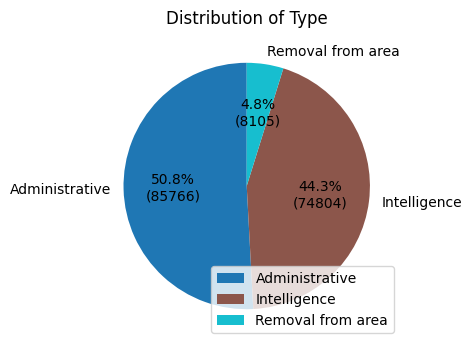

In [ ]:
# @title התפלגות סוגי האיתורים
type_counts = Offenses_Data['Type'].value_counts()

# יצירת גרף עוגה בגודל קטן יותר
plt.figure(figsize=(4, 4))
type_counts.plot.pie(autopct=lambda p: f'{p:.1f}%\n({int(p * sum(type_counts) / 100)})',
                      startangle=90, cmap='tab10', legend=True)
print("התפלגות סוגי האיתורים ('Type')")
plt.title("Distribution of Type")
plt.ylabel('')  # הסרת התווית של ציר ה-Y
plt.show()

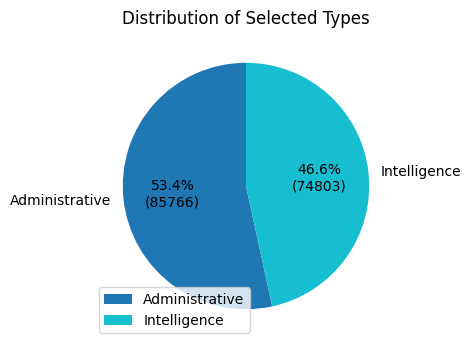

In [ ]:
import matplotlib.pyplot as plt

# סינון הנתונים כך שיכלול רק את הסוגים הרצויים
filtered_types = Offenses_Data[Offenses_Data['Type'].isin(['Intelligence', 'Administrative'])]

# חישוב ההתפלגות רק עבור הסוגים המסוננים
type_counts = filtered_types['Type'].value_counts()

# יצירת גרף עוגה בגודל קטן יותר
plt.figure(figsize=(4, 4))
type_counts.plot.pie(autopct=lambda p: f'{p:.1f}%\n({int(p * sum(type_counts) / 100)})',
                      startangle=90, cmap='tab10', legend=True)

plt.title("Distribution of Selected Types")
plt.ylabel('')  # הסרת התווית של ציר ה-Y
plt.show()


In [ ]:
Offenses_Data['Potential_Type'].value_counts() # כמה יש מכל סוג של פוטנשיאל טייפ

,count
Potential_Type,
sheds,51731
Land preparation for construction,25981
Removal from area,15051
fence,12834
concrete floor,9704
Skeleton in advanced construction,9602
Dirt roads or road paving,7683
Extra construction,7540
shading net,4464


In [ ]:
Offenses_Data['Case_Status'].value_counts()

,count
Case_Status,
new,135356
exist,33127
Rebuild,192


In [ ]:
Offenses_Data['District'].value_counts()

,count
District,
North,85851
Center,31942
Jerusalem,26262
South,24620


In [ ]:
Offenses_Data['Year'].value_counts()

,count
Year,
2017,30784
2020,29209
2021,26811
2022,21128
2018,19347
2019,19169
2023,16079
2024,6148


In [ ]:
# @title מכל סוג של פוטנישאל טייפ, כמה ערכים עם כל סוג של טייפ
# הדפסה עם הגדרת רוחב מלא
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pivot_table = pd.pivot_table(Offenses_Data, values='Auto_Number', index='Potential_Type', columns='Type', aggfunc='count', fill_value=0)
print(pivot_table)

Type                                                Administrative  Intelligence  Removal from area
Potential_Type                                                                                     
Dirt                                                             0            42                  0
Dirt roads or road paving                                       45          7638                  0
Drilling foundations                                           608             5                  0
End of construction                                            162             0                  0
Extra construction                                            6805           734                  1
Infrastructure for a permanent/temporary structure             808            87                  0
Land preparation for construction                             6107         19870                  4
Mobile structure                                              4312            39                  7


In [ ]:
# נניח שהנתונים כבר נטענו ל-DataFrame בשם Offenses_Data
filt = Offenses_Data[Offenses_Data['Case'] == 117]

# מציג את התוצאות
print(filt)

Empty DataFrame
Columns: [Case, Year, Update_Photo_Date, Previous_Photo_Date, District, Type, Potential_Type, Case_Status, Kal_Kashiah, Planning_Area, Local_Authority, City, Block, Parcel, X, Y, District_land_designation, Local_land_designation, Prevantion, Defence, Vatmal, Tzvir, Return, Auto_Number]
Index: []


In [ ]:
# @title מילוי X ו Y לפי מספר תיק

def fill_missing_coordinates(df):
#    משלימה ערכים חסרים בעמודות X ו-Y בהתבסס על מספרי תיק זהים בעמודת Case.

    # ניצור עותק של הטבלה לעבודה
    df = Offenses_Data.copy()

    # רשימת העמודות בהן נחפש ערכים חסרים
    coord_columns = ['X', 'Y']

    # נעבור על כל אחת מהעמודות ונשלים את הערכים החסרים
    for col in coord_columns:
        # מציאת ערכים חסרים
        missing_mask = df[col].isna()

        # לולאה על כל שורה עם ערכים חסרים
        for idx in df[missing_mask].index:
            # קבלת מספר התיק של השורה
            case_number = df.loc[idx, 'Case']

            # חיפוש ערך קיים בעמודה עם אותו מספר תיק
            replacement_value = df.loc[(df['Case'] == case_number) & df[col].notna(), col]

            # אם נמצא ערך מתאים, נשלים אותו
            if not replacement_value.empty:
                df.loc[idx, col] = replacement_value.iloc[0]

    return df

# קריאה לפונקציה
df_filled = fill_missing_coordinates(Offenses_Data)

missing_count = df_filled[[ 'X' , 'Y' ]].isna(). any (axis= 1 ). sum () # הדפסת התוצאה
print ( f"Number of records still missing X or Y: {missing_count} " )

# מחיקת רשומות שנותרו ללא ערכים ב-X או Y
Offenses_Data = df_filled.dropna(subset=['X', 'Y'])

# הדפסת מספר הרשומות שנמחקו
rows_dropped = len(df_filled) - len(Offenses_Data)
print(f"Number of records dropped: {rows_dropped}")
missing_count = Offenses_Data[[ 'X' , 'Y' ]].isna(). any (axis= 1 ). sum () # הדפסת התוצאה
print ( f"Number of records still missing X or Y: {missing_count} " )


Number of records still missing X or Y: 20 
Number of records dropped: 20
Number of records still missing X or Y: 0 


לאחר המילוי נשארו 20 רשומות ללא מיקומים שמחקנו אותם

עכשיו נמלא מספר תיק כי זו גם עמודה חשובה, כדי לדעת איך למלא מספר תיק נבצע ניתוח נתונים עבור תיקים קיימים

# **ניתוח הדאטה עבור רשומות עם מספרי תיק**
בקוד הבא אפשר לראות גרף השוואה של רשומות (רק אלו שיש להם מספר תיק) ותיקים יחודיים לפי הטייפ


השוואת רשומות ותיקים לכל קטגוריה:


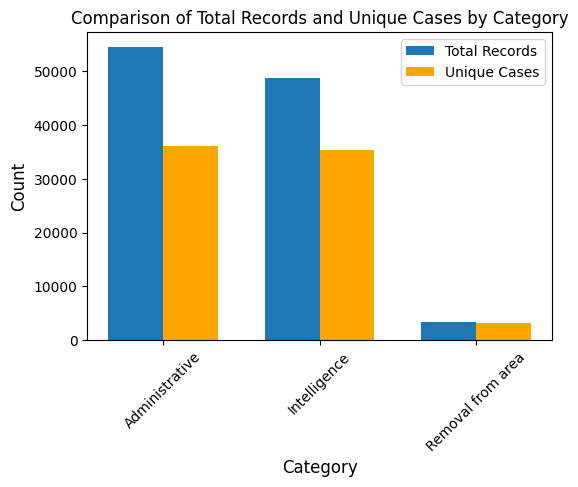

In [ ]:
# חישוב מספר הרשומות והמספר הייחודי של תיקים לכל קטגוריה
category_data = Offenses_Data.groupby('Type').agg(
    Total_Records=('Case', 'count'),
    Unique_Cases=('Case', 'nunique')
).reset_index()

# גרף השוואה כולל
print("\nהשוואת רשומות ותיקים לכל קטגוריה:")
plt.figure(figsize=(6, 4))
width = 0.35
x = range(len(category_data['Type']))
plt.bar(x, category_data['Total_Records'], width=width, label='Total Records')
plt.bar([i + width for i in x], category_data['Unique_Cases'], width=width, label='Unique Cases', color='orange')
plt.xticks([i + width / 2 for i in x], category_data['Type'], rotation=45)
plt.title('Comparison of Total Records and Unique Cases by Category', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.show()


# המשך ניתוח התפלגות מרחק בין תיקים
מתמקד רק ברשומות שבהן יש ערך בעמודת תיק ומחשב סטטיסטיקות על תיקים:



המרחקים בין הרשומות בתיק לפי עמודות X ו-Y.

תיקים עם גם מודיעיני וגם מנהלי:
מזהה תיקים שבהם יש רשומות משני הסוגים.

גרף של התפלגות המרחקים ההמוצעים בין רשומות בתיק.

סך כל התיקים: 64200
  סך כל הרשומות עם מספר תיק: 168655

מספר התיקים שבהם יש גם 'מודיעיני' וגם 'מנהלי': 8741


<ipython-input-17-a4e41f6242e1>:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  average_distance_per_case = valid_cases.groupby("Case").apply(compute_total_avg_distance).dropna()


 (עם יותר מרשומה אחת)התפלגות ממוצע כלל המרחקים בתוך כל תיק


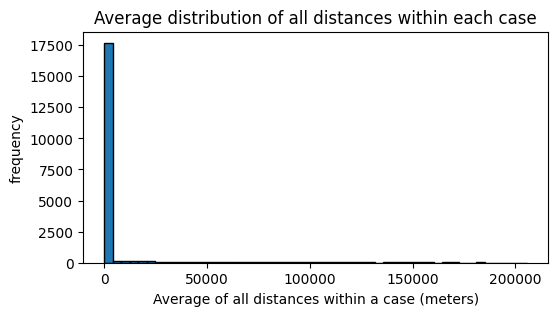

In [ ]:
# סינון הרשומות עם ערכים בעמודת 'Case' בלבד
filtered_data = Offenses_Data.dropna(subset=['Case'])

# תיקים עם גם מודיעיני וגם מנהלי
mixed_cases = filtered_data.groupby('Case').filter(
    lambda x: ('Intelligence' in x['Type'].values) and ('Administrative' in x['Type'].values)
)
mixed_case_count = mixed_cases['Case'].nunique()
# חישוב מספר התיקים הכולל
num_cases = Offenses_Data['Case'].nunique()

# חישוב מספר הרשומות הכולל
num_records = len(Offenses_Data)

# הצגת התוצאות
print("סך כל התיקים:", num_cases)
print("  סך כל הרשומות עם מספר תיק:", num_records)
print("\nמספר התיקים שבהם יש גם 'מודיעיני' וגם 'מנהלי':", mixed_case_count)

# סינון תיקים עם יותר מרשומה אחת עם קורדינטות תקפות
valid_cases = Offenses_Data.dropna(subset=["X", "Y"]).groupby("Case").filter(lambda x: len(x) > 1)

# פונקציה לחישוב מרחק אוקלידי בין שתי נקודות
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# פונקציה לחישוב ממוצע המרחקים הכולל בתוך כל תיק
def compute_total_avg_distance(group):
    coords = group[["X", "Y"]].values
    total_distances = []

    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            distance = euclidean_distance(coords[i][0], coords[i][1], coords[j][0], coords[j][1])
            total_distances.append(distance)

    return np.mean(total_distances) if total_distances else np.nan

# חישוב הממוצע הכולל של המרחקים בתוך כל תיק - עבור תיקים עם יותר מרשומה אחת
average_distance_per_case = valid_cases.groupby("Case").apply(compute_total_avg_distance).dropna()

# הצגת התפלגות הממוצע הכולל של המרחקים לכל תיק
print(" (עם יותר מרשומה אחת)התפלגות ממוצע כלל המרחקים בתוך כל תיק")
plt.figure(figsize=(6, 3))
plt.hist(average_distance_per_case, bins=50, edgecolor="black")
plt.xlabel("Average of all distances within a case (meters)")
plt.ylabel("frequency")
plt.title("Average distribution of all distances within each case")
plt.show()


קוד שמוריד את כל התיקים שהמרחק ביניהם הוא מעל 100 מטר - לפי ההגדרה של הרשות

In [ ]:
# @title הסרה של רשומות מעל 100 מטר
# שמירת העתק של הדאטה המקורי
original_df = Offenses_Data.copy()

# 🎯 שמירה על כל הנתונים אך ניקוי רק של רשומות עם X, Y חסרים
df_filtered = Offenses_Data.dropna(subset=['X', 'Y']).copy()

# 🔧 ניקוי מזהי תיקים מכל פסיקים והמרתם למספרים שלמים (רק עבור רשומות עם מספר תיק תקף)
df_filtered.loc[df_filtered['Case'].notna(), 'Case'] = (
    df_filtered['Case'].astype(str).str.replace(',', '').astype(float).astype('Int64')
)
cases_to_remove = set()

for case_id, group in df_filtered.groupby("Case"):
    if pd.notna(case_id) and len(group) > 1:  # רק תיקים עם יותר מרשומה
        coords = group[['X', 'Y']].values
        found_large_distance = False  # משתנה שיעקוב אם יש מרחקים מעל 100 מטר

        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                distance = np.sqrt((coords[j][0] - coords[i][0])**2 + (coords[j][1] - coords[i][1])**2)
                if distance > 100:
                    found_large_distance = True
                    break  # מספיק למצוא מרחק אחד כדי לסמן תיק להסרה

            if found_large_distance:
                cases_to_remove.add(case_id)
                break  # אין צורך לבדוק עוד באותו תיק

# המרת Case למספרים שלמים (אם ניתן)
Offenses_Data['Case'] = Offenses_Data['Case'].astype(str).str.replace(',', '').astype(float).astype('Int64')

# הסרת התיקים שסומנו
Offenses_Data = Offenses_Data[~Offenses_Data['Case'].isin(cases_to_remove)]

# בדיקה מחדש האם ההסרה עבדה
print(f"📌 מספר התיקים אחרי ההסרה: {Offenses_Data['Case'].nunique()}")


📌 מספר התיקים אחרי ההסרה: 61382


<ipython-input-18-de9990f93e3d>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Offenses_Data['Case'] = Offenses_Data['Case'].astype(str).str.replace(',', '').astype(float).astype('Int64')


In [ ]:
# @title ניתוח התיקים שוב

# סינון הרשומות עם ערכים בעמודת 'Case' בלבד
filtered_data = Offenses_Data.dropna(subset=['Case'])

# תיקים עם גם מודיעיני וגם מנהלי
mixed_cases = filtered_data.groupby('Case').filter(
    lambda x: ('Intelligence' in x['Type'].values) and ('Administrative' in x['Type'].values)
)
mixed_case_count = mixed_cases['Case'].nunique()
# חישוב מספר התיקים הכולל
num_cases = Offenses_Data['Case'].nunique()

# חישוב מספר הרשומות הכולל
num_records = len(Offenses_Data)

# הצגת התוצאות
print("סך כל התיקים:", num_cases)
print("  סך כל הרשומות עם מספר תיק:", num_records)
print("\nמספר התיקים שבהם יש גם 'מודיעיני' וגם 'מנהלי':", mixed_case_count)

סך כל התיקים: 61382
  סך כל הרשומות עם מספר תיק: 160152

מספר התיקים שבהם יש גם 'מודיעיני' וגם 'מנהלי': 7228


על מנת שנדע כיצד להתקדם במילוי הערכים החסרים נמצא התפלגויות :
התפלגות מרחקי התיקים

# חישוב התפלגות מרחק בין תיקים
כדי שנוכל לראות התפלגות נכונה ומדויקת הסרנו תיקים עם מרחק גדול וחריג ביניהם (מעל 100 מטר)

נמצא את ההתפלגות של מרחקי התיקים,
את השונות
ואת ממוצע וחציון המרחקים שאיתם נוכל לשייך רשומות לאותו תיק

Average of Mean Distances: 8.165766782205829
Median of Mean Distances: 5.312034048607599
Number of cases processed: 17351
   Case  Mean_Distance  Variance_Distance
0     7       0.000000           0.000000
1     8       2.000000           0.000000
2     9      12.165525           0.000000
3    12      17.073139          61.841267
4    15       0.000000           0.000000
התפלגות ממוצעי המרחקים בתיקים


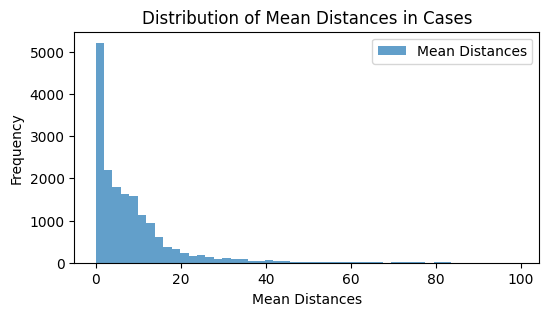

התפלגות שונות המרחקים בתיקים


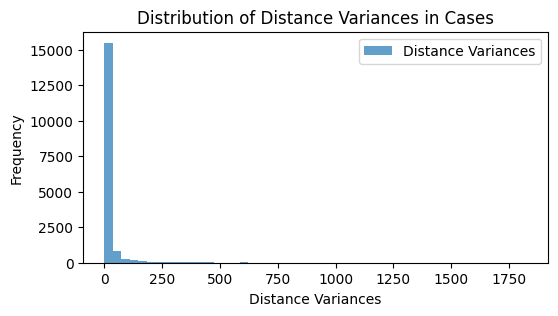

In [ ]:
# טיפול בתיקונים בעמודה של מספרי התיקים
# סינון רשומות ללא מספר תיק
df = Offenses_Data[Offenses_Data['Case'].notnull()]
# יצירת פונקציה לחישוב התפלגות ושונות המרחקים בכל תיק
def calculate_distance_distribution(data):
    results = []

    for case_id, group in data.groupby('Case'):
        # בדיקה מוקדמת: התיק חייב להכיל יותר מרשומה אחת
        if len(group) <= 1:
            continue

   # חישוב מרחקים בין הקורדינטות בקבוצה
        coordinates = group[['X', 'Y']].values
        distances = pdist(coordinates)
        mean_distance = np.mean(distances)
        variance_distance = np.var(distances)
        results.append({'Case': case_id, 'Mean_Distance': mean_distance, 'Variance_Distance': variance_distance})

    return pd.DataFrame(results)

# חישוב התפלגות המרחקים בכל תיק
case_distributions = calculate_distance_distribution(df)

# חישוב ממוצע הממוצעים וחציון הממוצעים
mean_of_means = case_distributions['Mean_Distance'].mean()
median_of_means = case_distributions['Mean_Distance'].median()

print(f"Average of Mean Distances: {mean_of_means}")
print(f"Median of Mean Distances: {median_of_means}")

# הצגת מספר התיקים שעברו את החישוב
print(f"Number of cases processed: {case_distributions.shape[0]}")

# הצגת כמה שורות ראשונות מהתוצאות
print(case_distributions.head())

# הצגת התפלגויות ושונות
plt.figure(figsize=(6, 3))
plt.hist(case_distributions['Mean_Distance'], bins=50, alpha=0.7, label='Mean Distances')
plt.xlabel('Mean Distances')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Distances in Cases')
print("התפלגות ממוצעי המרחקים בתיקים")
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
plt.hist(case_distributions['Variance_Distance'], bins=50, alpha=0.7, label='Distance Variances')
plt.xlabel('Distance Variances')
plt.ylabel('Frequency')
plt.title('Distribution of Distance Variances in Cases')
print("התפלגות שונות המרחקים בתיקים")
plt.legend()
plt.show()



מילוי מספרי תיקים לפי המרחק של החציון - 5.31

In [ ]:
# פונקציה לעיבוד נתונים
def process_missing_cases_stage1(data, max_distance=5.31):
    # יצירת עותק של הנתונים (כדי לא לשנות את הנתונים המקוריים)
    data_copy = data.copy()

    # ספירת הערכים החסרים בעמודת 'Case' לפני העיבוד
    missing_before = data_copy['Case'].isna().sum()

    # הפרדה לרשומות עם ובלי ערכים בעמודת 'Case'
    missing_case_rows = data_copy[data_copy['Case'].isna()]
    existing_case_rows = data_copy[data_copy['Case'].notna()]

    # יצירת עץ KD לנקודות עם ערכים קיימים
    existing_points = existing_case_rows[['X', 'Y']].values
    existing_cases = existing_case_rows['Case'].values
    existing_dates = existing_case_rows['Update_Photo_Date'].values  # שמירת תאריך הצילום
    kd_tree = cKDTree(existing_points)

    # מציאת שכנים קרובים לנקודות עם ערכים חסרים
    missing_points = missing_case_rows[['X', 'Y']].values
    distances, indices = kd_tree.query(missing_points, distance_upper_bound=max_distance)

    # מילוי הערכים החסרים בשלב הראשון
    records_filled = 0  # מספר הרשומות שמולאו
    cases_filled = set()  # סט של תיקים שמולאו
    filled_records_indices = []  # רשומות שמולאו
    for i, (distance, index) in enumerate(zip(distances, indices)):
        if index < len(existing_cases):  # אם נמצא שכן קרוב במרחק מתאים
            case_value = existing_cases[index]
            update_date = existing_dates[index]
            missing_record_date = missing_case_rows.iloc[i]['Update_Photo_Date']

            # לוודא שלא מדובר באותו תאריך צילום
            if update_date != missing_record_date:
                data_copy.loc[missing_case_rows.index[i], 'Case'] = case_value
                records_filled += 1
                cases_filled.add(case_value)
                filled_records_indices.append(missing_case_rows.index[i])

       # ספירת הערכים החסרים לאחר השלב הראשון
    missing_after_first_stage = data_copy['Case'].isna().sum()

    print(f"רשומות עם מספר תיק חסר לפני השלב הראשון: {missing_before}")
    print(f"רשומות שמולאו בשלב הראשון: {records_filled}")
    print(f"תיקים ייחודיים שמולאו בשלב הראשון: {len(cases_filled)}")
    print(f"רשומות עם מספר תיק חסר לאחר השלב הראשון: {missing_after_first_stage}")

    return data_copy

# קריאה לפונקציה ושמירה של התוצאה
Offenses_Data = process_missing_cases_stage1(Offenses_Data)


רשומות עם מספר תיק חסר לפני השלב הראשון: 61894
רשומות שמולאו בשלב הראשון: 12242
תיקים ייחודיים שמולאו בשלב הראשון: 7777
רשומות עם מספר תיק חסר לאחר השלב הראשון: 49652


יצירת תיקים חדשים ושיול רשומות לאותו תיק לפי המרחק ביניהם (5.31)

In [ ]:
def process_missing_cases_stage2(data):
    # יצירת עותק של הנתונים כדי לא לשנות את המקור
    data_copy = data.copy()

    # רשומות שעדיין חסרות מספר תיק
    remaining_missing = data_copy[data_copy['Case'].isna()].copy()

    # בניית עץ KDTree לחיפוש קרובים במהירות
    tree_remaining = cKDTree(remaining_missing[['X', 'Y']].values)

    # מציאת כל הזוגות הקרובים (מרחק <= 5.31)
    pairs = tree_remaining.query_pairs(5.31)

    # יצירת גרף לחיבור קבוצות נקודות קרובות
    G = nx.Graph()
    G.add_edges_from(pairs)

    # מציאת קבוצות מחוברות של נקודות
    components = list(nx.connected_components(G))

    # מספר תיק התחלתי לשיוך קבוצות
    case_number = 100000

    # שיוך מספרי תיקים לכל קבוצה
    for component in components:
        indices = list(component)
        for idx in indices:
            real_idx = remaining_missing.index[idx]  # המרת אינדקס פנימי לאינדקס דאטה מקורי
            data_copy.at[real_idx, 'Case'] = case_number
        case_number += 1

    # ספירת מספרי התיקים הייחודיים שהוקצו
    unique_cases_filled = len(components)
       # ספירת הערכים החסרים לאחר השלב השני
    missing_after_second_stage = data_copy['Case'].isna().sum()


    print(f"מספר תיקים ייחודיים שמולאו: {unique_cases_filled}")
    print(f"רשומות עם מספר תיק חסר לאחר השלב השני: {missing_after_second_stage}")


    # מילוי שאר הרשומות החסרות במספרי תיקים חדשים
    if missing_after_second_stage > 0:
        remaining_indices = data_copy[data_copy['Case'].isna()].index
        for idx in remaining_indices:
            data_copy.at[idx, 'Case'] = case_number
            case_number += 1

    # בדיקה סופית של כמות הרשומות החסרות
    final_missing = data_copy['Case'].isna().sum()
    print(f"רשומות ללא מספר תיק לאחר השלמה סופית: {final_missing}")


    return data_copy

# קריאה לפונקציה עם הנתונים המעודכנים
Offenses_Data = process_missing_cases_stage2(Offenses_Data)


מספר תיקים ייחודיים שמולאו: 7338
רשומות עם מספר תיק חסר לאחר השלב השני: 32452
רשומות ללא מספר תיק לאחר השלמה סופית: 0


כעת ארצה לבצע התפלגות תיקים כבקשת הילל-

In [ ]:
def analyze_case_distribution(data):
    # חישוב התפלגות רשומות לכל מספר תיק
    case_distribution = data['Case'].value_counts()

    # חישוב ערכים סטטיסטיים על מספר הרשומות לכל תיק
    min_records = case_distribution.min()
    max_records = case_distribution.max()
    avg_records = case_distribution.mean()

    # חישוב מספר התיקים הייחודיים
    unique_cases_count = data['Case'].nunique()

    # קיבוץ לפי 'Case' ובדיקת סט הערכים בעמודת 'Type'
    case_with_types = data.groupby('Case')['Type'].apply(set)

    # סינון המקרים שמכילים את שני הערכים 'Administrative' ו-'Intelligence'
    cases_with_both_types = case_with_types[case_with_types.apply(lambda x: {'Administrative', 'Intelligence'}.issubset(x))].index

    # סינון המקרים שמכילים רק את 'Administrative'
    cases_with_only_administrative = case_with_types[case_with_types.apply(lambda x: x == {'Administrative'})].index

    # סינון המקרים שמכילים רק את 'Intelligence'
    cases_with_only_intelligence = case_with_types[case_with_types.apply(lambda x: x == {'Intelligence'})].index
    cases_with_only_remove = case_with_types[case_with_types.apply(lambda x: x == {'Removal from area'})].index
    # הצגת התוצאות
    print(f"מספר התיקים שמכילים את שני הערכים 'Administrative' ו-'Intelligence': {len(cases_with_both_types)}")
    print(f"מספר התיקים שמכילים רק את 'Administrative': {len(cases_with_only_administrative)}")
    print(f"מספר התיקים שמכילים רק את 'Intelligence': {len(cases_with_only_intelligence)}")
    print(f"מספר התיקים שמכילים רק את 'Removal from area': {len(cases_with_only_remove)}")
    # פלט הנתונים
    print(f"מספר הרשומות המינימלי לתיק: {min_records}")
    print(f"מספר הרשומות המקסימלי לתיק: {max_records}")
    print(f"מספר הרשומות הממוצע לתיק: {avg_records:.2f}")
    print(f"מספר התיקים הייחודיים: {unique_cases_count}")

    return cases_with_both_types

# קריאה לפונקציה
cases_with_both_types = analyze_case_distribution(Offenses_Data)

# אם רוצים להציג את מספרי התיקים עצמם
if not cases_with_both_types.empty:
    print("מספרי התיקים שמכילים גם 'Administrative' וגם 'Intelligence':")
    print(cases_with_both_types.tolist())


מספר התיקים שמכילים את שני הערכים 'Administrative' ו-'Intelligence': 10382
מספר התיקים שמכילים רק את 'Administrative': 43450
מספר התיקים שמכילים רק את 'Intelligence': 41220
מספר התיקים שמכילים רק את 'Removal from area': 2433
מספר הרשומות המינימלי לתיק: 1
מספר הרשומות המקסימלי לתיק: 31
מספר הרשומות הממוצע לתיק: 1.58
מספר התיקים הייחודיים: 101172
מספרי התיקים שמכילים גם 'Administrative' וגם 'Intelligence':
[5, 8, 15, 18, 24, 25, 27, 28, 46, 52, 62, 65, 68, 71, 80, 81, 87, 88, 89, 93, 94, 97, 110, 112, 114, 131, 133, 136, 138, 151, 156, 171, 177, 185, 194, 195, 196, 198, 199, 204, 206, 209, 212, 215, 217, 244, 247, 252, 254, 256, 257, 260, 262, 268, 272, 273, 278, 279, 280, 284, 287, 288, 289, 294, 298, 300, 302, 304, 305, 315, 323, 332, 339, 348, 349, 350, 351, 353, 354, 356, 358, 367, 369, 370, 372, 375, 376, 381, 384, 385, 389, 393, 396, 397, 403, 412, 415, 418, 419, 420, 421, 422, 429, 434, 435, 436, 437, 440, 447, 450, 453, 456, 483, 486, 495, 503, 505, 507, 508, 512, 516, 517, 519, 

נרצה לבדוק איזה תיקים התחילו ממודיעיני והפכו למנהלי

In [ ]:
def find_intelligence_to_admin_cases(data):
    # קיבוץ הנתונים לפי 'Case' ומיון הרשומות בתוך כל תיק לפי 'Update_Photo_Date'
    sorted_data = data.sort_values(by=['Case', 'Update_Photo_Date'])

    # רשימת תיקים שמכילים גם 'Administrative' וגם 'Intelligence'
    case_with_types = sorted_data.groupby('Case')['Type'].apply(set)
    cases_with_both_types = case_with_types[case_with_types.apply(lambda x: {'Administrative', 'Intelligence'}.issubset(x))].index

    # איתור התיקים שבהם 'Intelligence' קדם ל-'Administrative'
    intelligence_to_admin_cases = []

    for case in cases_with_both_types:
        case_data = sorted_data[sorted_data['Case'] == case]  # נתונים עבור תיק ספציפי
        types_in_order = case_data['Type'].tolist()           # רשימת הסוגים לפי סדר התאריכים

        # בדיקה אם 'Intelligence' מופיע לפני 'Administrative'
        if 'Administrative' in types_in_order and 'Intelligence' in types_in_order:
            intel_index = types_in_order.index('Intelligence')
            admin_index = types_in_order.index('Administrative')
            if intel_index < admin_index:  # 'Intelligence' מופיע קודם
                intelligence_to_admin_cases.append(case)

    # הצגת התוצאה
    print(f"מספר התיקים שבהם 'Intelligence' קדם ל-'Administrative': {len(intelligence_to_admin_cases)}")
    print("מספרי התיקים:")
    print(intelligence_to_admin_cases)

    return intelligence_to_admin_cases

# קריאה לפונקציה
intelligence_to_admin_cases = find_intelligence_to_admin_cases(Offenses_Data)


מספר התיקים שבהם 'Intelligence' קדם ל-'Administrative': 5592
מספרי התיקים:
[np.int64(8), np.int64(15), np.int64(27), np.int64(68), np.int64(71), np.int64(80), np.int64(87), np.int64(89), np.int64(93), np.int64(94), np.int64(110), np.int64(112), np.int64(114), np.int64(138), np.int64(151), np.int64(156), np.int64(171), np.int64(177), np.int64(195), np.int64(198), np.int64(199), np.int64(204), np.int64(206), np.int64(215), np.int64(252), np.int64(254), np.int64(256), np.int64(257), np.int64(260), np.int64(278), np.int64(279), np.int64(280), np.int64(287), np.int64(289), np.int64(300), np.int64(305), np.int64(348), np.int64(349), np.int64(351), np.int64(356), np.int64(369), np.int64(376), np.int64(384), np.int64(396), np.int64(415), np.int64(418), np.int64(421), np.int64(434), np.int64(437), np.int64(450), np.int64(456), np.int64(495), np.int64(503), np.int64(505), np.int64(521), np.int64(525), np.int64(547), np.int64(548), np.int64(566), np.int64(570), np.int64(579), np.int64(588), np.in

In [ ]:
Offenses_Data.isnull().sum() #כמה ריקים יש בכל עמודה

,0
Case,0
Year,0
Update_Photo_Date,0
Previous_Photo_Date,0
District,0
Type,0
Potential_Type,0
Case_Status,0
Kal_Kashiah,0
Planning_Area,19699


In [ ]:
# @title פונקציה להשלמת ערכי עיר בעמודה 'City' בהתבסס על מספרי תיקים
def fill_missing_cities(data):
    # בדיקת ערכים חסרים בעמודת "City" לפני העיבוד
    missing_cities_before = data['City'].isnull().sum()
    print(f"מספר רשומות עם ערכים חסרים בעמודת 'City' לפני השלמה: {missing_cities_before}")

    # יצירת מפה שמקשרת בין מספר תיק לעיר
    case_to_city_map = data.groupby('Case')['City'].apply(
        lambda x: x.dropna().iloc[0] if not x.dropna().empty else None
    ).to_dict()

    # מילוי הערכים החסרים בעמודת 'City' לפי המפה
    data['City_Filled'] = data['Case'].map(case_to_city_map)
    data['City'] = data['City'].fillna(data['City_Filled'])

    # בדיקת ערכים חסרים לאחר העיבוד
    missing_cities_after = data['City'].isnull().sum()
    print(f"מספר רשומות עם ערכים חסרים בעמודת 'City' לאחר השלמה: {missing_cities_after}")

    # מחיקת עמודת העזר
    data.drop(columns=['City_Filled'], inplace=True)

    return data

# קריאה לפונקציה לאחר השלמת מספרי תיקים
Offenses_Data = fill_missing_cities(Offenses_Data)

מספר רשומות עם ערכים חסרים בעמודת 'City' לפני השלמה: 20745
מספר רשומות עם ערכים חסרים בעמודת 'City' לאחר השלמה: 20236


עכשיו נשלים את החסרים לפי רדיוס של 5 קמ
למה דווקא 5?
מספיק קטן כדי להבדיל בין ערים סמוכות באזורים צפופים.
מספיק גדול כדי לכסות אזורים כפריים/פריפריאליים.

In [ ]:
def fill_city_by_distance(data, radius=5000):
    # פילטר רשומות עם ובלי עיר
    known_cities = data.dropna(subset=['City'])
    missing_cities = data[data['City'].isnull()]

    # בניית עץ חיפוש מהיר עבור הקורדינטות של ערים ידועות
    tree = cKDTree(known_cities[['X', 'Y']].values)

    # חיפוש הקרובים ביותר עבור הרשומות החסרות
    distances, indices = tree.query(missing_cities[['X', 'Y']].values, k=1)

    # עדכון רשומות בתוך הרדיוס בלבד
    mask = distances <= radius
    missing_cities.loc[mask, 'City'] = known_cities.iloc[indices[mask]]['City'].values

    # עדכון הנתונים בחזרה
    data.update(missing_cities)

    return data

# הפעלת הפונקציה על הנתונים
Offenses_Data = fill_city_by_distance(Offenses_Data, radius=5000)

cvf1= Offenses_Data['City'].isnull().sum()
print(f"מספר רשומות עם ערכים חסרים בעמודת 'City' לאחר השלמה: {cvf1}")

מספר רשומות עם ערכים חסרים בעמודת 'City' לאחר השלמה: 143


In [ ]:
# מילוי כל הערכים החסרים ב-'City' עם 'NoCity'
Offenses_Data['City'].fillna('NoCity', inplace=True)

# ספירת מספר הרשומות שהושלמו בערך 'NoCity'
no_city_count = (Offenses_Data['City'] == 'NoCity').sum()

# ספירת מספר הרשומות שעדיין ריקות (אמור להיות 0)
cvf2 = Offenses_Data['City'].isnull().sum()

# הדפסת התוצאות
print(f"מספר הרשומות שהושלמו עם 'NoCity': {no_city_count}")
print(f"מספר הרשומות שנותרו ריקות: {cvf2}")

מספר הרשומות שהושלמו עם 'NoCity': 143
מספר הרשומות שנותרו ריקות: 0


<ipython-input-28-c422f3f3d727>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Offenses_Data['City'].fillna('NoCity', inplace=True)


מילוי רשות מקומית

הנה הקוד למילוי ערכים חסרים בעמודת "רשות מקומית" (Local_Authority) לפי השלבים שהגדרת:

שלב ראשון: מילוי לפי ערך "תיק" (Case) – מחפש רשומות עם אותו מספר תיק ומעתיק את הערך הקיים.
שלב שני: אם הערך עדיין חסר, מחפש לפי "עיר" (City) ומעתיק את הערך מהרשומה שנמצאה (רק אם העיר אינה "NoCity").
הדפסת סיכום – כמה ערכים מולאו וכמה עדיין חסרים.

In [ ]:
def fill_missing_local_authority(data):
    # יצירת עותק של הנתונים כדי לא לפגוע במקור
    data_copy = data.copy()

    # ספירת הערכים החסרים לפני תחילת התהליך
    missing_before = data_copy['Local_Authority'].isna().sum()

    # מילוי לפי מספר תיק (Case)
    case_mapping = data_copy.dropna(subset=['Local_Authority']).groupby('Case')['Local_Authority'].first()
    data_copy['Local_Authority'] = data_copy.apply(
        lambda row: case_mapping[row['Case']] if pd.isna(row['Local_Authority']) and row['Case'] in case_mapping else row['Local_Authority'],
        axis=1
    )

    # מילוי לפי עיר (City) כאשר העיר אינה 'NoCity'
    city_mapping = data_copy[(data_copy['City'] != 'NoCity') & data_copy['Local_Authority'].notna()].groupby('City')['Local_Authority'].first()
    data_copy['Local_Authority'] = data_copy.apply(
        lambda row: city_mapping[row['City']] if pd.isna(row['Local_Authority']) and row['City'] in city_mapping else row['Local_Authority'],
        axis=1
    )

    # ספירת הערכים החסרים אחרי המילוי
    missing_after = data_copy['Local_Authority'].isna().sum()
    filled_count = missing_before - missing_after

    print(f"ערכים חסרים בעמודת 'Local_Authority' לפני: {missing_before}")
    print(f"ערכים שמולאו: {filled_count}")
    print(f"ערכים חסרים בעמודת 'Local_Authority' אחרי: {missing_after}")

    return data_copy

# קריאה לפונקציה ועדכון הנתונים
Offenses_Data = fill_missing_local_authority(Offenses_Data)


ערכים חסרים בעמודת 'Local_Authority' לפני: 533
ערכים שמולאו: 533
ערכים חסרים בעמודת 'Local_Authority' אחרי: 0


השלמת ערכים חסרים בעמודת

 "מרחב תכנון" (Planning_Area)

  בשלושה שלבים
הקוד הבא מוסיף שלב שלישי שבו מתבצע מילוי לפי "רשות מקומית" (Local_Authority) אם הערך עדיין חסר אחרי המילוי לפי "Case" ו-"City".

שלבי המילוי:
שלב ראשון: מילוי לפי "תיק" (Case).
שלב שני: מילוי לפי "עיר" (City), כל עוד העיר אינה "NoCity".
שלב שלישי (חדש!): מילוי לפי "רשות מקומית" (Local_Authority).

In [ ]:
def fill_missing_planning_area(data):
    # יצירת עותק של הנתונים כדי לא לשנות את המקור
    data_copy = data.copy()

    # ספירת הערכים החסרים לפני תחילת התהליך
    missing_before = data_copy['Planning_Area'].isna().sum()

    # שלב 1: מילוי לפי מספר תיק (Case)
    case_mapping = data_copy.dropna(subset=['Planning_Area']).groupby('Case')['Planning_Area'].first()
    data_copy['Planning_Area'] = data_copy.apply(
        lambda row: case_mapping[row['Case']] if pd.isna(row['Planning_Area']) and row['Case'] in case_mapping else row['Planning_Area'],
        axis=1
    )

    # שלב 2: מילוי לפי עיר (City) כאשר העיר אינה 'NoCity'
    city_mapping = data_copy[(data_copy['City'] != 'NoCity') & data_copy['Planning_Area'].notna()].groupby('City')['Planning_Area'].first()
    data_copy['Planning_Area'] = data_copy.apply(
        lambda row: city_mapping[row['City']] if pd.isna(row['Planning_Area']) and row['City'] in city_mapping else row['Planning_Area'],
        axis=1
    )

    # שלב 3: מילוי לפי רשות מקומית (Local_Authority)
    authority_mapping = data_copy[data_copy['Planning_Area'].notna()].groupby('Local_Authority')['Planning_Area'].first()
    data_copy['Planning_Area'] = data_copy.apply(
        lambda row: authority_mapping[row['Local_Authority']] if pd.isna(row['Planning_Area']) and row['Local_Authority'] in authority_mapping else row['Planning_Area'],
        axis=1
    )

    # ספירת הערכים החסרים אחרי המילוי
    missing_after = data_copy['Planning_Area'].isna().sum()
    filled_count = missing_before - missing_after

    print(f"ערכים חסרים בעמודת 'Planning_Area' לפני: {missing_before}")
    print(f"ערכים שמולאו: {filled_count}")
    print(f"ערכים חסרים בעמודת 'Planning_Area' אחרי: {missing_after}")

    return data_copy

# קריאה לפונקציה ועדכון הנתונים
Offenses_Data = fill_missing_planning_area(Offenses_Data)

ערכים חסרים בעמודת 'Planning_Area' לפני: 19699
ערכים שמולאו: 19699
ערכים חסרים בעמודת 'Planning_Area' אחרי: 0


השלמת יעוד קרקע ממחוזי

לשכתב את זה לפני ששמים בדוח:

בדאטה קיימות שתי עמודות המתייחסות לייעוד קרקע, ״ייעוד קרקע מקומי״ ו״ייעוד קרקע מחוזי״. מכיוון שייעוד קרקע מחוזי במהות שלו זהה או מכיל בתוכו לרוב את ייעוד הקרקע המקומי, על פי הגדרות התכנון, העדפנו לעבוד עם העמודה של ״ייעוד קרקע מחוזי״. ליתר ביטחון ביצענו בדיקה כדי להבין באיזו עמודה חסרים יותר ערכים, כיוון שבסוף השאיפה היא לעבוד עם כמה שיותר ערכיים מקוריים, לאחר שווידאנו שב״ייעוד קרקע מחוזי״ ישנם יותר ערכים מלאים החלטנו סופית לעבוד עם העמודה הזו.

🔍 מילוי ערכים חסרים בעמודת "ייעוד קרקע מחוזי" (District_land_designation) עם חמישה שלבים
📌 שלבי המילוי:
1️⃣ מילוי לפי תיק (Case)
2️⃣ מילוי לפי ייעוד קרקע מקומי (Local_land_designation)
3️⃣ מילוי לפי עיר (City) (רק אם העיר ≠ "NoCity")
4️⃣ מילוי לפי רשות מקומית (Local_Authority)
5️⃣ מילוי לפי מרחב תכנון (Planning_Area)

בנוסף, הקוד מתייחס לערכים "---" כערכים חסרים.

In [ ]:
def fill_missing_district_land(data):
    # יצירת עותק של הנתונים כדי לא לשנות את המקור
    data_copy = data.copy()

    # המרת ערכים '---' לערכים חסרים (NaN)
    Offenses_Data.loc[Offenses_Data['District_land_designation'] == '---', 'District_land_designation'] = np.nan
    print(Offenses_Data[Offenses_Data['District_land_designation'] == '---'])

    # ספירת הערכים החסרים לפני תחילת התהליך
    missing_before = data_copy['District_land_designation'].isna().sum()

    # שלב 1: מילוי לפי מספר תיק (Case)
    case_mapping = data_copy.dropna(subset=['District_land_designation']).groupby('Case')['District_land_designation'].first()
    data_copy['District_land_designation'] = data_copy.apply(
        lambda row: case_mapping[row['Case']] if pd.isna(row['District_land_designation']) and row['Case'] in case_mapping else row['District_land_designation'],
        axis=1
    )

    # שלב 2: מילוי לפי ייעוד קרקע מקומי (Local_land_designation)
    data_copy['District_land_designation'] = data_copy.apply(
        lambda row: row['Local_land_designation'] if pd.isna(row['District_land_designation']) and pd.notna(row['Local_land_designation']) else row['District_land_designation'],
        axis=1
    )

    # שלב 3: מילוי לפי עיר (City) כאשר העיר אינה 'NoCity'
    city_mapping = data_copy[(data_copy['City'] != 'NoCity') & data_copy['District_land_designation'].notna()].groupby('City')['District_land_designation'].first()
    data_copy['District_land_designation'] = data_copy.apply(
        lambda row: city_mapping[row['City']] if pd.isna(row['District_land_designation']) and row['City'] in city_mapping else row['District_land_designation'],
        axis=1
    )

    # שלב 4: מילוי לפי רשות מקומית (Local_Authority)
    authority_mapping = data_copy[data_copy['District_land_designation'].notna()].groupby('Local_Authority')['District_land_designation'].first()
    data_copy['District_land_designation'] = data_copy.apply(
        lambda row: authority_mapping[row['Local_Authority']] if pd.isna(row['District_land_designation']) and row['Local_Authority'] in authority_mapping else row['District_land_designation'],
        axis=1
    )

    # שלב 5: מילוי לפי מרחב תכנון (Planning_Area)
    planning_mapping = data_copy[data_copy['District_land_designation'].notna()].groupby('Planning_Area')['District_land_designation'].first()
    data_copy['District_land_designation'] = data_copy.apply(
        lambda row: planning_mapping[row['Planning_Area']] if pd.isna(row['District_land_designation']) and row['Planning_Area'] in planning_mapping else row['District_land_designation'],
        axis=1
    )

    # ספירת הערכים החסרים אחרי המילוי
    missing_after = data_copy['District_land_designation'].isna().sum()
    filled_count = missing_before - missing_after

    print(f"ערכים חסרים בעמודת 'District_land_designation' לפני: {missing_before}")
    print(f"ערכים שמולאו: {filled_count}")
    print(f"ערכים חסרים בעמודת 'District_land_designation' אחרי: {missing_after}")

    return data_copy

# קריאה לפונקציה ועדכון הנתונים
Offenses_Data = fill_missing_district_land(Offenses_Data)


Empty DataFrame
Columns: [Case, Year, Update_Photo_Date, Previous_Photo_Date, District, Type, Potential_Type, Case_Status, Kal_Kashiah, Planning_Area, Local_Authority, City, Block, Parcel, X, Y, District_land_designation, Local_land_designation, Prevantion, Defence, Vatmal, Tzvir, Return, Auto_Number]
Index: []
ערכים חסרים בעמודת 'District_land_designation' לפני: 26294
ערכים שמולאו: 26294
ערכים חסרים בעמודת 'District_land_designation' אחרי: 0


7.	מילוי ערכים חסרים בעמודות ״מניעה״, ״הגנה״, ״השבה״ ו״ותמל״ - מרחבים אלו הינם מרחבי עבודה שהרשות לאכיפה במקרקעין הגדירה לעצמה כמרחבים שבהם האכיפה הינה קריטית והרמטית יותר. כל שטח גיאוגרפי יכול להיות משויך למרחב אחד בלבד, או לא להיות משויך לשום מרחב. ולכן עשינו גרופבי לפי תיק עם המרחב ומילאנו את הערכים החסרים לפי מה שקיים בתיק ברשומות אחרות. במידה ולא קיים המשמעות היא שהרשומה לא משויכת למרחב ולכן הערך שהיא קיבלה הוא ״לא״.


מילוי ערכים חסרים בעמודות ״מניעה״, ״הגנה״, ״השבה״ ו״ותמל

מילוי ערכים חסרים בעמודת "Prevantion"

הקוד הבא ממלא את הערכים החסרים בעמודת Prevantion בשני שלבים: 1️⃣ מילוי לפי מספר תיק (Case) - אם נמצא ערך בעמודת Prevantion עבור אותו מספר תיק, הערך יועתק.
2️⃣ מילוי בערך "No" עבור ערכים שנותרו חסרים.

In [ ]:
def fill_missing_prevention(data):
    # יצירת עותק של הנתונים כדי לא לשנות את המקור
    data_copy = data.copy()

    # ספירת הערכים החסרים לפני תחילת התהליך
    missing_before = data_copy['Prevantion'].isna().sum()

    # שלב 1: מילוי לפי מספר תיק (Case)
    case_mapping = data_copy.dropna(subset=['Prevantion']).groupby('Case')['Prevantion'].first()
    data_copy['Prevantion'] = data_copy.apply(
        lambda row: case_mapping[row['Case']] if pd.isna(row['Prevantion']) and row['Case'] in case_mapping else row['Prevantion'],
        axis=1
    )

    # שלב 2: מילוי ב-"No" עבור ערכים שעדיין חסרים
    data_copy['Prevantion'].fillna('No', inplace=True)

    # ספירת הערכים החסרים אחרי המילוי
    missing_after = data_copy['Prevantion'].isna().sum()
    filled_count = missing_before - missing_after

    print(f"ערכים חסרים בעמודת 'Prevantion' לפני: {missing_before}")
    print(f"ערכים שמולאו: {filled_count}")
    print(f"ערכים חסרים בעמודת 'Prevantion' אחרי: {missing_after}")

    return data_copy

# קריאה לפונקציה ועדכון הנתונים
Offenses_Data = fill_missing_prevention(Offenses_Data)


ערכים חסרים בעמודת 'Prevantion' לפני: 66032
ערכים שמולאו: 66032
ערכים חסרים בעמודת 'Prevantion' אחרי: 0


<ipython-input-32-856e9fa04279>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_copy['Prevantion'].fillna('No', inplace=True)


In [ ]:
def fill_missing_defence(data):
    # יצירת עותק של הנתונים כדי לא לשנות את המקור
    data_copy = data.copy()

    # ספירת הערכים החסרים לפני תחילת התהליך
    missing_before = data_copy['Defence'].isna().sum()

    # שלב 1: מילוי לפי מספר תיק (Case)
    case_mapping = data_copy.dropna(subset=['Defence']).groupby('Case')['Defence'].first()
    data_copy['Defence'] = data_copy.apply(
        lambda row: case_mapping[row['Case']] if pd.isna(row['Defence']) and row['Case'] in case_mapping else row['Defence'],
        axis=1
    )

    # שלב 2: מילוי ב-"No" עבור ערכים שעדיין חסרים
    data_copy['Defence'].fillna('No', inplace=True)

    # ספירת הערכים החסרים אחרי המילוי
    missing_after = data_copy['Defence'].isna().sum()
    filled_count = missing_before - missing_after

    print(f"ערכים חסרים בעמודת 'Defence' לפני: {missing_before}")
    print(f"ערכים שמולאו: {filled_count}")
    print(f"ערכים חסרים בעמודת 'Defence' אחרי: {missing_after}")

    return data_copy

# קריאה לפונקציה ועדכון הנתונים
Offenses_Data = fill_missing_defence(Offenses_Data)


ערכים חסרים בעמודת 'Defence' לפני: 66261
ערכים שמולאו: 66261
ערכים חסרים בעמודת 'Defence' אחרי: 0


<ipython-input-33-a0a2dca737e2>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_copy['Defence'].fillna('No', inplace=True)


In [ ]:
def fill_missing_vatmal(data):
    # יצירת עותק של הנתונים כדי לא לשנות את המקור
    data_copy = data.copy()

    # ספירת הערכים החסרים לפני תחילת התהליך
    missing_before = data_copy['Vatmal'].isna().sum()

    # שלב 1: מילוי לפי מספר תיק (Case)
    case_mapping = data_copy.dropna(subset=['Vatmal']).groupby('Case')['Vatmal'].first()
    data_copy['Vatmal'] = data_copy.apply(
        lambda row: case_mapping[row['Case']] if pd.isna(row['Vatmal']) and row['Case'] in case_mapping else row['Vatmal'],
        axis=1
    )

    # שלב 2: מילוי ב-"No" עבור ערכים שעדיין חסרים
    data_copy['Vatmal'].fillna('No', inplace=True)

    # ספירת הערכים החסרים אחרי המילוי
    missing_after = data_copy['Vatmal'].isna().sum()
    filled_count = missing_before - missing_after

    print(f"ערכים חסרים בעמודת 'Vatmal' לפני: {missing_before}")
    print(f"ערכים שמולאו: {filled_count}")
    print(f"ערכים חסרים בעמודת 'Vatmal' אחרי: {missing_after}")

    return data_copy

# קריאה לפונקציה ועדכון הנתונים
Offenses_Data = fill_missing_vatmal(Offenses_Data)


ערכים חסרים בעמודת 'Vatmal' לפני: 11481
ערכים שמולאו: 11481
ערכים חסרים בעמודת 'Vatmal' אחרי: 0


<ipython-input-34-56890a1a38e1>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_copy['Vatmal'].fillna('No', inplace=True)


In [ ]:
def fill_missing_return(data):
    # יצירת עותק של הנתונים כדי לא לשנות את המקור
    data_copy = data.copy()

    # ספירת הערכים החסרים לפני תחילת התהליך
    missing_before = data_copy['Return'].isna().sum()

    # שלב 1: מילוי לפי מספר תיק (Case)
    case_mapping = data_copy.dropna(subset=['Return']).groupby('Case')['Return'].first()
    data_copy['Return'] = data_copy.apply(
        lambda row: case_mapping[row['Case']] if pd.isna(row['Return']) and row['Case'] in case_mapping else row['Return'],
        axis=1
    )

    # שלב 2: מילוי ב-"No" עבור ערכים שעדיין חסרים
    data_copy['Return'].fillna('No', inplace=True)

    # ספירת הערכים החסרים אחרי המילוי
    missing_after = data_copy['Return'].isna().sum()
    filled_count = missing_before - missing_after

    print(f"ערכים חסרים בעמודת 'Return' לפני: {missing_before}")
    print(f"ערכים שמולאו: {filled_count}")
    print(f"ערכים חסרים בעמודת 'Return' אחרי: {missing_after}")

    return data_copy

# קריאה לפונקציה ועדכון הנתונים
Offenses_Data = fill_missing_return(Offenses_Data)


ערכים חסרים בעמודת 'Return' לפני: 66032
ערכים שמולאו: 66032
ערכים חסרים בעמודת 'Return' אחרי: 0


<ipython-input-35-4973d4db4160>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_copy['Return'].fillna('No', inplace=True)


In [ ]:
Offenses_Data.isnull().sum() #כמה ריקים יש בכל עמודה

,0
Case,0
Year,0
Update_Photo_Date,0
Previous_Photo_Date,0
District,0
Type,0
Potential_Type,0
Case_Status,0
Kal_Kashiah,0
Planning_Area,0


עכשיו, לאחר שמילאנו את כל העמודות אנחנו יכולות להסיר רשומות שהם 'הסרה מהשטח'  מכיוון שאלו לא רלוונטים לבניית המודל והסיווג

📌 הסרת רשומות עם ערך "Removal from area" בעמודות Type או Potential_Type
כעת נסיר מהדאטה את כל הרשומות שבהן העמודות Type או Potential_Type מכילות את הערך "Removal from area".

In [ ]:
def remove_removal_from_area(data):
    # ספירת הרשומות לפני הסינון
    records_before = len(data)

    # סינון הרשומות שבהן Type או Potential_Type מכילים "Removal from area"
    data_filtered = data[~((data['Type'] == 'Removal from area') | (data['Potential_Type'] == 'Removal from area'))]

    # ספירת הרשומות אחרי הסינון
    records_after = len(data_filtered)
    removed_count = records_before - records_after

    print(f"מספר הרשומות לפני הסינון: {records_before}")
    print(f"מספר הרשומות שהוסרו: {removed_count}")
    print(f"מספר הרשומות לאחר הסינון: {records_after}")

    return data_filtered

# קריאה לפונקציה ועדכון הנתונים
Offenses_Data = remove_removal_from_area(Offenses_Data)


מספר הרשומות לפני הסינון: 160152
מספר הרשומות שהוסרו: 14977
מספר הרשומות לאחר הסינון: 145175


הוספת עמודות:


1.   רבעון
2.   עירוני - כן/לא
3. יהודי - כן/לא




הוספת עמודת רבעון

בכך, הוספת עמודה בשם Quarter שתכיל את הרבעון של כל תאריך בעמודת Update_Photo_Date. לדוגמה:

רבעון 1: ינואר - מרץ
רבעון 2: אפריל - יוני
רבעון 3: יולי - ספטמבר
רבעון 4: אוקטובר - דצמבר

In [ ]:
# המרת העמודה Update_Photo_Date לטיפוס datetime אם היא לא בפורמט המתאים
Offenses_Data['Update_Photo_Date'] = pd.to_datetime(Offenses_Data['Update_Photo_Date'], errors='coerce')

# יצירת עמודת הרבעון עם הסימון "Q" לפני המספר
Offenses_Data['Quarter_Update'] = "Q" + Offenses_Data['Update_Photo_Date'].dt.quarter.astype(str)


<ipython-input-38-1cdd70e52ecc>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  Offenses_Data['Update_Photo_Date'] = pd.to_datetime(Offenses_Data['Update_Photo_Date'], errors='coerce')
<ipython-input-38-1cdd70e52ecc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Offenses_Data['Update_Photo_Date'] = pd.to_datetime(Offenses_Data['Update_Photo_Date'], errors='coerce')


התאמת ערכי עיר מאופנסס דאטה לסיטי דאטה כדי שנוכל לשים לכל עיר דת והאם זה עיר או לא

עשינו לי התאמת של 85 אחוז באותיות, אלו שלא היו נכונים שינינו ידנית

In [ ]:
df1 = Offenses_Data
df2 = data_city

# שמות הערים משני הקבצים
cities_fdataa = df1["City"].dropna().unique()
cities_sug_ir = df2["name_city"].dropna().unique()

# סינון ערכים שכבר תואמים
matched_cities = set(cities_fdataa) & set(cities_sug_ir)
cities_to_match = set(cities_fdataa) - matched_cities

# יצירת מילון התאמות
city_mapping = {}
manual_corrections = {

    "Tira": "Tire",
    "Dali'at el Carmel": "Daliyat Al-Karmel",
    "Baka al Garbiyya": "Baqa Al-Gharbiyye",
    "Abu Basma": "Umm Al-Fahm",
    "Rama": "Rame",
    "Paki'in Hachadasha": "Peqi'in Hadasha",
    "Paki'in (Bukiyeh)": "Peqi'in (Buqei'a)",
    "Kasra-Samiya": "Kisra-Sumei",
    "Hazor": "Hazor-Ashdod",
    "Kfar Vradim": "Kefar Weradim",
    "Osha": "Usha",
    "Zalfon": "Zelafon",
    "Jessar al-Zarqa": "Jisr Az-Zarqa",
    "Aco": "Akko",
    "Yarka": "Yirka",
    "Yanoh-Jeth": "Yanuh-Jat",
    "Kadarim": "Qaddarim",
    "Meuna": "Me'ona",
    "Horfish": "Hurfeish",
    "Aylabon": "Eilabun",
    "Araba": "Arrabe",
    "Buaina-Nojidat": "Bu'eine-Nujeidat",
    "Eksal": "Iksal",
    "Nazeret": "Nazareth",
    "Basmat Tivon": "Basmat Tab'un",
    "Jaljulia": "Jaljulye",
    "Givat Haim (Union)": "Giv'at Hayyim (Ihud)",
    "Taiba": "Tayibe",
    "Toval": "Tuval",
    "Abtin": "Ibtin",
    "Zechariah": "Zekharya",
    "Katzrin": "Qazrin",
    "Tveria": "Tiberias",
    "Zikim": "Ziqim",
    "Odim": "Udim",
    "Shfaiim": "Shefayim",
    "Zavon": "Ziv'on",
    "Afek": "Afeq",
    "Zvia": "Zova",
    "Romet Heev": "Ramat HaSharon",
    "Amikam": "Ammiqam",
    "Gamzu": "Gimzo",
    "Yeshrash": "Yesodot",
    "Brechia": "Berekhya",
    "Kedma": "Qedma",
    "Geia": "Geva",
    "Beit Yanai": "Bet Yannay",
    "Beit Chelkiya": "Bet Hilqiyya",
    "Usafia": "Isifya",
    "Baka-Jat": "Jatt",
    "Usafia": "Isifya",
    "Barkai": "Barqay",
    'Kazir-Harish': 'Harish',
    'Shaeb': "Sha'ab",
    'Jedidah-Makher': 'Judeide-Maker',
    'Ein Yaakov': "En Ya'aqov",
    'Amuka': 'Amuqqa',
    'Machmenim': 'Mahanayim',
    'Reiyna': 'Reine',
    'Dovrat': 'Daverat',
    'Mashhad': 'Massad',
    'Kineret': 'Kinneret(Qevuza)',
    'Givat Haim': "Giv'at Hayyim (Ihud)",
    'Kamana': "Sawa'id (Kamane)",
    'Matan': 'Matta',
    'Zapariya': 'Zafriyya',
    'Matsuba': 'Mazzuva',
    'Muzmuz': 'Musmus',
    'Kfar Hoshen': 'Hosen',
    'Neve Yerek': 'Newe Yaraq',
    'Keisarya': 'Qesariyya',
    'Merhavia': 'Merhavya (Moshav)',
    'Nayan': "Na'an",
    'Kaduri': 'Kadoorie',
    'Nof Hagalil': 'Gornot HaGalil',
    'Kfar Yedidia': 'Yedidya',
    'Lakyia': 'Lakhish',
    'Yatir': 'Mahane Yattir',
    'Yakum': 'Yaqum',
    'Bnei Brak': 'Bene Beraq',
    'Kfar Matzer': 'Mezer',
    'Romana': 'Rummane',
     'Kedron': 'Qidron',
    'Kislon': 'Kesalon',
    'Mahasia': 'Mahseya',
    'Tarom': 'Tarum',
    'Neve Michael': "Newe Mikha'el",
    'Amatzia': 'Amazya',
    'Bnei Aiysh': 'Bene Ayish',
    'Brur Chail': 'Beror Hayil',
    'Rihaniya': 'Reihaniyye',
    'Bnei Zion': 'Bene Ziyyon',
    'Achisemech': 'Ahisamakh',
    'Hodaya': 'Hodiyya',
    'Zerakhia': 'Zerahya',
    'Revacha': 'Rewaha',
    'Ynon': 'Yinnon',
    'Nativ Hal"h': 'Netiv HaLamed-He',
    'Beit Yitzhak': "Bet Yizhaq-Sh. Hefer",
    'Tzuva': 'Tuval',
    'Shazur': 'Shezor',
    'Kamun': 'Kammon',
    "Bana": "Bi'ne",
    "Mailia": "Mi'elya",
    "Ablein": "I'Billin",
    'Farzun': 'Perazon',
    'Mokaybela': 'Muqeible',
}

for city in cities_to_match:
    if city in manual_corrections:
        city_mapping[city] = manual_corrections[city]
    else:
        match, score = process.extractOne(city, cities_sug_ir)
        if score > 80:
            city_mapping[city] = match

# המרת שמות הערים בעזרת המילון (עדכון ישירות בעמודת City)
df1["City"] = df1["City"].map(city_mapping).fillna(df1["City"])

# בדיקה של ערים שלא קיבלו התאמה (ערים שלא קיימות ב- name_city)
unmatched_cities = df1[~df1["City"].isin(df2["name_city"])]["City"].unique()

# מספר הערים שלא קיבלו התאמה
num_unmatched = len(unmatched_cities)
print(f"מספר הערים שלא קיבלו התאמה: {num_unmatched}")

# הצגת דוגמאות מערים שלא קיבלו התאמה
print(" דוגמאות לערים ללא התאמה:")
print(unmatched_cities[:100])


מספר הערים שלא קיבלו התאמה: 2
 דוגמאות לערים ללא התאמה:
['easyקיליה' 'NoCity']


In [ ]:
# המרת 'easyקיליה' ל-'NoCity'
df1.loc[df1["City"] == "easyקיליה", "City"] = "NoCity"

# מיזוג הנתונים לפי עיר
OAfter = df1.merge(df2[['name_city', 'city_erea', 'jewish_e']], left_on='City', right_on='name_city', how='left')

# הסרת עמודת ה-name_city שנוספה למנוע כפילויות
OAfter.drop(columns=['name_city'], inplace=True)

# החלפת ערכים עבור NoCity
OAfter.loc[OAfter['City'] == 'NoCity', ['city_erea', 'jewish_e']] = 'No'

print("להמשך עיבוד ונשמר כ-OAfter.")

להמשך עיבוד ונשמר כ-OAfter.


In [ ]:
OAfter.head(10)

,Case,Year,Update_Photo_Date,Previous_Photo_Date,District,Type,Potential_Type,Case_Status,Kal_Kashiah,Planning_Area,Local_Authority,City,Block,Parcel,X,Y,District_land_designation,Local_land_designation,Prevantion,Defence,Vatmal,Tzvir,Return,Auto_Number,Quarter_Update,city_erea,jewish_e
0,1,2017,2017-04-19,21/03/2017 0:00,Center,Intelligence,Land preparation for construction,new,hard,Petah Tikva,Petah Tikva,Petah Tiqwa,6351.0,10.0,189331.0,669085.0,Extensive recreation area,NaN,No,No,No,NaN,No,11431,Q2,Yes,Yes
1,3,2019,2019-03-09,04/01/2019 0:00,Center,Administrative,Skeleton in advanced construction,new,hard,Kesem,Kfar Qasem,Kafar Qasem,8883.0,5.0,197685.0,668134.0,Forest,Agricultural land and pasture,No,No,No,NaN,No,50053,Q1,No,No
2,5,2017,2017-03-21,19/02/2017 0:00,Center,Administrative,skeleton structure,exist,hard,Kesem,Kfar Qasem,Kafar Qasem,8870.0,45.0,198602.0,669764.0,Forest,NaN,No,No,No,NaN,No,9645,Q1,No,No
3,7,2017,2017-03-21,19/02/2017 0:00,Center,Administrative,skeleton structure,exist,hard,Kesem,Kfar Qasem,Kafar Qasem,8870.0,72.0,197968.0,669672.0,Urban development area,NaN,No,No,No,NaN,No,9615,Q1,No,No
4,7,2017,2017-04-19,21/03/2017 0:00,Center,Administrative,skeleton structure,exist,hard,Kesem,Kfar Qasem,Kafar Qasem,8870.0,72.0,197968.0,669672.0,Urban development area,NaN,No,No,No,NaN,No,11580,Q2,No,No
5,8,2017,2017-03-21,19/02/2017 0:00,Center,Administrative,skeleton structure,exist,hard,Kesem,Kfar Qasem,Kafar Qasem,8868.0,58.0,196445.0,669276.0,Agricultural area/ open countryside,NaN,Yes,No,No,NaN,No,9591,Q1,No,No
6,8,2020,2020-03-09,14/02/2020 0:00,Center,Intelligence,Land preparation for construction,new,hard,Kesem,Kfar Qasem,Kafar Qasem,8868.0,58.0,196445.0,669274.0,Agricultural area/ open countryside,Agricultural land and pasture,Yes,No,No,NaN,No,69719,Q1,No,No
7,10,2017,2017-04-19,21/03/2017 0:00,Center,Intelligence,Dirt roads or road paving,new,hard,Kesem,Kfar Qasem,Kafar Qasem,8867.0,49.0,195146.0,669122.0,Agricultural area/ open countryside,NaN,No,No,No,NaN,No,11487,Q2,No,No
8,12,2023,2023-06-09,15/05/2023 0:00,Center,Intelligence,shading net,exist,easy,Kesem,Kfar Qasem,Kafar Qasem,8874.0,75.0,195229.0,669947.0,Agricultural land and pasture,Agricultural land and pasture,Yes,No,No,NaN,No,23-6-1-0024,Q2,No,No
9,12,2020,2020-07-03,08/06/2020 0:00,Center,Intelligence,Land preparation for construction,new,hard,Kesem,Kfar Qasem,Kafar Qasem,8874.0,75.0,195223.0,669946.0,Agricultural area/ open countryside,Agricultural land and pasture,Yes,No,No,NaN,No,78867,Q3,No,No


עד פה בעצם עשינו פרהפרוססינג ומילאנו את כל העמודות החסרות. בנסוף הוספנו עמודות שחשבנו שיוכלו לתת לנו עוד נתונים.

מפה אנחנו בונות את הדאטה פריים. אנו הופכות את כל התיקים לרשומה אחת ואז נהפוך את הדאטה לנורמרי כדי שנוכל להריץ עליו מודלים

מה עדיף לפרויקט שלך?
כיוון שהמטרה שלך היא לנבא האם איתור מודיעיני יהפוך למנהלי, כדאי קודם לאחד כל תיק לרשומה אחת כדי להבין איך התיק מתפתח. לאחר מכן, אפשר להוסיף עמודות בינאריות רק עבור מאפיינים רלוונטיים, ולא לכל עמודה.

In [ ]:
# @title תיקים עם קודם מודיעיני ואז מנהלי
def find_intelligence_to_admin_cases(data):
    # קיבוץ הנתונים לפי 'Case' ומיון הרשומות בתוך כל תיק לפי 'Update_Photo_Date'
    sorted_data = data.sort_values(by=['Case', 'Update_Photo_Date'])

    # איתור תיקים שמכילים גם 'Administrative' וגם 'Intelligence'
    case_with_types = sorted_data.groupby('Case')['Type'].apply(set)
    cases_with_both_types = case_with_types[case_with_types.apply(lambda x: {'Administrative', 'Intelligence'}.issubset(x))].index

    # רשימת תיקים שבהם 'Intelligence' הופיע לפני 'Administrative'
    intelligence_to_admin_cases = []

    for case in cases_with_both_types:
        case_data = sorted_data[sorted_data['Case'] == case]  # נתונים עבור תיק ספציפי
        types_in_order = case_data['Type'].values  # רשימת הסוגים לפי סדר התאריכים

        # מציאת כל האינדקסים של 'Intelligence' ו-'Administrative'
        intel_indices = np.where(types_in_order == 'Intelligence')[0]
        admin_indices = np.where(types_in_order == 'Administrative')[0]

        # בדיקה אם קיים מופע של 'Intelligence' לפני כל מופע של 'Administrative'
        if np.any(intel_indices[:, None] < admin_indices):
            intelligence_to_admin_cases.append(case)

    # הצגת התוצאה
    print(f"מספר התיקים שבהם 'Intelligence' קדם ל-'Administrative': {len(intelligence_to_admin_cases)}")
    print("מספרי התיקים:")
    print(intelligence_to_admin_cases)

    return intelligence_to_admin_cases

# קריאה לפונקציה
intelligence_to_admin_cases = find_intelligence_to_admin_cases(OAfter)

מספר התיקים שבהם 'Intelligence' קדם ל-'Administrative': 6786
מספרי התיקים:
[np.int64(5), np.int64(24), np.int64(25), np.int64(28), np.int64(46), np.int64(52), np.int64(62), np.int64(65), np.int64(68), np.int64(71), np.int64(80), np.int64(81), np.int64(87), np.int64(88), np.int64(89), np.int64(131), np.int64(133), np.int64(136), np.int64(151), np.int64(156), np.int64(171), np.int64(177), np.int64(185), np.int64(194), np.int64(195), np.int64(196), np.int64(199), np.int64(204), np.int64(209), np.int64(212), np.int64(215), np.int64(217), np.int64(244), np.int64(247), np.int64(252), np.int64(254), np.int64(256), np.int64(257), np.int64(262), np.int64(268), np.int64(272), np.int64(273), np.int64(278), np.int64(279), np.int64(287), np.int64(289), np.int64(294), np.int64(300), np.int64(302), np.int64(305), np.int64(332), np.int64(339), np.int64(348), np.int64(349), np.int64(350), np.int64(351), np.int64(367), np.int64(369), np.int64(370), np.int64(372), np.int64(376), np.int64(381), np.int64(3

התפלגות תיקים עם יותר מרשומה אחת

יחס תיקים בהם 'Intelligence' קדם ל-'Administrative' מתוך כלל התיקים
יחס תיקים בהם 'Intelligence' קדם ל-'Administrative' מתוך תיקים עם יותר מרשומה אחת


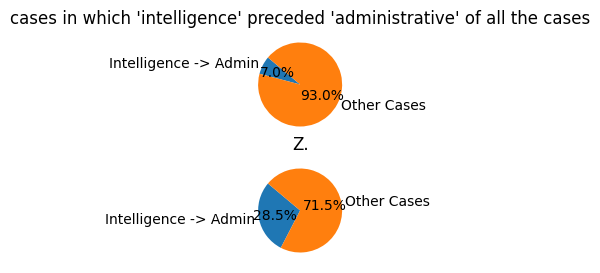

In [ ]:
def plot_intelligence_to_admin_cases(data, intelligence_to_admin_cases):
    # סך כל התיקים
    total_cases = data['Case'].nunique()
    intelligence_to_admin_count = len(intelligence_to_admin_cases)
    other_cases_count = total_cases - intelligence_to_admin_count

    # פילוח תיקים עם יותר מרשומה אחת
    cases_with_multiple_entries = data['Case'].value_counts()
    cases_with_multiple_entries = cases_with_multiple_entries[cases_with_multiple_entries > 1].index
    intelligence_to_admin_multiple = len(set(intelligence_to_admin_cases) & set(cases_with_multiple_entries))
    other_multiple_cases = len(cases_with_multiple_entries) - intelligence_to_admin_multiple

    # יצירת גרפים
    fig, axes = plt.subplots(2, 1, figsize=(6, 3))

    # גרף 1 - כל התיקים
    print ("יחס תיקים בהם 'Intelligence' קדם ל-'Administrative' מתוך כלל התיקים")
    axes[0].pie([intelligence_to_admin_count, other_cases_count], labels=['Intelligence -> Admin', 'Other Cases'],
                autopct='%1.1f%%', startangle=140)
    axes[0].set_title("cases in which 'intelligence' preceded 'administrative' of all the cases")

    # גרף 2 - תיקים עם יותר מרשומה אחת
    print ("יחס תיקים בהם 'Intelligence' קדם ל-'Administrative' מתוך תיקים עם יותר מרשומה אחת")
    axes[1].pie([intelligence_to_admin_multiple, other_multiple_cases], labels=['Intelligence -> Admin', 'Other Cases'],
                autopct='%1.1f%%', startangle=140)
    axes[1].set_title("Z.")

    # הצגת הגרפים
    plt.show()

# קריאה לפונקציה להצגת הגרפים
plot_intelligence_to_admin_cases(OAfter, intelligence_to_admin_cases)


מכיוון שאנו עוסקים בהאם תיק יהפוך ממודיעיני למנהלי אנו בעצם צרכים לבדוק רק תיקים שיש להם יותר מרשומה אחת.

לכן מפה נסיר את כל התיקים שיש להם רק רשומה אחת.

ונסדר את כל הרשומות בתיק לפי הסדר הכרונולוגי

קוד להסרת תיקים עם רשומה אחת וסידור לפי תאריך
הקוד הבא:

סופר את מספר הרשומות לכל תיק.
מסיר את כל התיקים שמופיעים רק פעם אחת.
מסדר את הרשומות של כל תיק לפי Update_Photo_Date.

In [ ]:
#@title  הורדת תיקים עם רשומה אחת וסידור רשומות לפי תאריך

# ספירת מספר הרשומות לכל תיק
case_counts = OAfter["Case"].value_counts()

# שמירת רק תיקים שמופיעים יותר מפעם אחת
cases_to_keep = case_counts[case_counts > 1].index
df_filtered = OAfter[OAfter["Case"].isin(cases_to_keep)]

# סידור הרשומות לפי מספר התיק ותאריך העדכון
OAfter = df_filtered.sort_values(by=["Case", "Update_Photo_Date"])


כדי לדעת איך בדיוק נהפוך כל תיק לרשומה אחת, נבין כמה רשומות ניקח לכל תיק.

נמתא את התפלגות הרשומות בתיק

ממוצע הרשומות לתיק: 3.03
חציון הרשומות לתיק: 2.0
התפלגות הרשומות בתיקים (רק תיקים עם יותר מרשומה אחת)


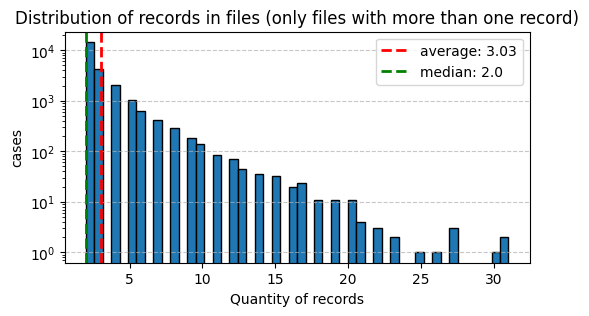

In [ ]:
# @title התפלגות רשומות בתיק
# ספירת מספר הרשומות לכל תיק
case_counts = OAfter['Case'].value_counts()

# סינון תיקים עם יותר מרשומה אחת
filtered_cases = case_counts[case_counts > 1]

# חישוב ממוצע וחציון
mean_cases = filtered_cases.mean()
median_cases = filtered_cases.median()

# הצגת נתונים סטטיסטיים
print(f"ממוצע הרשומות לתיק: {mean_cases:.2f}")
print(f"חציון הרשומות לתיק: {median_cases}")

# יצירת היסטוגרמה לקבוצות תיקים בגודל דומה
print("התפלגות הרשומות בתיקים (רק תיקים עם יותר מרשומה אחת)")
plt.figure(figsize=(6,3))
plt.hist(filtered_cases, bins=50, edgecolor='black', log=True)  # סולם לוגריתמי לנראות טובה יותר
plt.axvline(mean_cases, color='r', linestyle='dashed', linewidth=2, label=f'average: {mean_cases:.2f}')
plt.axvline(median_cases, color='g', linestyle='dashed', linewidth=2, label=f'median: {median_cases}')
plt.xlabel("Quantity of records")
plt.ylabel("cases")
plt.title("Distribution of records in files (only files with more than one record)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


גישה של 2 רשומות
✔️ תואמת לרוב התיקים (כי החציון הוא 2).
✔️ מאזנת בין שמירה על מידע קריטי לבין הפחתת מורכבות הנתונים.
✔️ מתאימה במיוחד אם רוב השינוי בתיק מתרחש ב-2 שלבים קריטיים (למשל, רגע המעבר למנהלי + הרשומה האחרונה).


גישה של 3 רשומות
❌ ברוב התיקים יש רק 2 רשומות, כך שהתוספת עשויה להיות מיותרת במקרים רבים.
❌ עלולה להוסיף מורכבות מיותרת למודל (נפח נתונים גדול יותר).

זה התפלגות תיקים עם מעל רשומה אחת, חשבנו לקחת לכל תיק 2 רשומות לפי החציון, כי אם ניקח לפי 3 תיקים (הממוצע) אז זה יעשה בעיה לכל התיקים עם 2 רשומות..


את גם הקלטת על ה הסבר להלל. תחפשי את ההודעה או את התמונה של ההתפלגות

בקיצור החלטנו לקחת 2 רשומות

**הסבר על איך ניקח 2 מכל תיק**

נפריד את המקרים :
1.    ת**יקים שיש בה רק מודיעיני/מנהלי:** ניקח את הרשומה האחרונה בתיק זה (כי מה שמעניין זה איך נגמר התיק) ואת הרשומה האחת לפניו (שהיא הכי משפיעה על הרשומה אחריה).

2.   ת**יקים שיש בהם גם מודיעיני וגם מנהלי והם מתחילים במודיעיני:**י נחפש בתיק זה את הרשומה הראשונה שהיא מנהלית וניקח אותה ואת הרשומה לפניה (כי הרשומה שלפני הכי משפיעה, ולא כל הרשומות לפניה) ואז כל עוד הרשומות ממשיכות להיות מנהליות והתיק ממשיך להיות מנהלי זה לא מעניין כי הוא כבר הפך למנהלי. אם בשלב כלשהו (אחרי הרשומה המנהלית הראשונה או שיש ברצף אחרי עוד כמה)יש רשומה מודיעינית אנו נתייחס לזה כתיק חדש החל מהרשומה המודיעינית (עם כל הרשומות שבאות אחריה). כי ברגע שתיק הופך להיות מנהלי הרשות מתחילה לאכוף אותו. ולכן במקרה שתיק שהיתה בו רשומה מנהלי ואז רשומה מודיעינית, החל מהרשומה המודיעינית נפתח תיק חדש. ואז שוב, נחפש בה את הרשומה המנהלית הראשונה וכו'.

זה לא משנה באיזה שלב התיק הפך ממודיעיני למנהלי, אם זה בהתחלה, באמצע או בסוף, מה שמשנה זה הרגע שהוא הפך למנהלי. ברגע שתיק
הפך למנהלי ניקח את הרשומה של המנהליואת הרשומה לפניה שהיא הכי הכי השפיעה על התיק לפני הפיכתו למנהלי.


3. ת**יקים שיש בהם גם מודיעיני וגם מנהלי והם מתחילים ממנהלי יחיד**, להסיר את המנהלי הראשון ואז בעצם מתחיל תיק חדש מהמודיעיני שבא האחרי הרשומה הראשונה של המנהלי
4. ת**יקים שיש בהם גם מודיעיני וגם מנהלי והם מתחילים מזוג או יותר של רשומות מנהליות** ואז הופך למודיעיני, אז נתייחס לרשומות המנהליות הראשונות (עד לרשומה המודיעינית, לא כולל אותה) כתיק מנהלי טהור ומהרשומה המודיעינית נפתח תיק חדש



עבור הערכים השונים שיש לכל עבירה נעשה 2 עמודות שונות וערכים שמשותפים לכל התיק (ל2 העבירות) נשאיר עמודה 1

In [ ]:
def process_cases(df):
    result = []
    # קיבוץ לפי תיק
    cases = df.groupby("Case")
    cases_info = {}  # מידע סטטיסטי על התיקים שעובדו

    for case_id, group in cases:
        # מיון הרשומות לפי תאריך
        group = group.sort_values("Update_Photo_Date", kind='mergesort')
        group["Type"] = group["Type"].str.lower()
        group_indices = group.index.to_list()
        new_case_suffix = 0

        # שמירת המידע המקורי לסטטיסטיקות
        cases_info[case_id] = {
            "original_count": len(group_indices),
            "original_types": ", ".join(group.loc[group_indices, "Type"].tolist()),
            "new_cases": []
        }

        if len(group_indices) == 0:
            continue

        # בדיקה אם כל הרשומות מאותו סוג (מודיעיני או מנהלי)
        all_intel = all(group.loc[idx, "Type"] == "intelligence" for idx in group_indices)
        all_admin = all(group.loc[idx, "Type"] == "administrative" for idx in group_indices)

        if all_intel or all_admin:
            # מקרה 1: כל הרשומות מאותו סוג (מודיעיני או מנהלי)
            new_case_name = f"{case_id}_NEW_{new_case_suffix}"
            if len(group_indices) >= 2:
                # בחירת הרשומה האחרונה והרשומה שלפניה
                result.extend([(group_indices[-2], new_case_name),
                               (group_indices[-1], new_case_name)])

                # עדכון סטטיסטיקות
                cases_info[case_id]["new_cases"].append({
                    "name": new_case_name,
                    "count": 2,
                    "types": group.loc[[group_indices[-2], group_indices[-1]], "Type"].tolist()
                })
            elif len(group_indices) == 1:
                # אם יש רק רשומה אחת, נדלג עליה לפי הכללים החדשים
                pass
            continue

        # בדיקה אם התיק מתחיל ברשומה מנהלית
        if group.loc[group_indices[0], "Type"] == "administrative":
            # מציאת כל הרשומות המנהליות הראשונות ברצף
            admin_indices = []
            for idx in group_indices:
                if group.loc[idx, "Type"] == "administrative":
                    admin_indices.append(idx)
                else:
                    break

            # מקרה 3: אם התיק מתחיל ברשומה מנהלית אחת בלבד
            if len(admin_indices) == 1:
                # דילוג על הרשומה המנהלית הראשונה ועיבוד השאר כתיק חדש
                remaining_indices = group_indices[1:]
                if len(remaining_indices) > 0:
                    process_subcases(remaining_indices, group, case_id, new_case_suffix, result, cases_info)

            # מקרה 4: מספר רשומות מנהליות לפני רשומות מודיעיניות
            elif len(admin_indices) > 1:
                # שמירת הרשומות המנהליות כתיק נפרד (בחירת שתי האחרונות אם זמינות)
                new_case_name = f"{case_id}_NEW_{new_case_suffix}"
                if len(admin_indices) >= 2:
                    result.extend([(admin_indices[-2], new_case_name),
                                   (admin_indices[-1], new_case_name)])

                    # עדכון סטטיסטיקות
                    cases_info[case_id]["new_cases"].append({
                        "name": new_case_name,
                        "count": 2,
                        "types": group.loc[[admin_indices[-2], admin_indices[-1]], "Type"].tolist()
                    })
                else:
                    # דילוג על רשומה בודדת
                    pass

                new_case_suffix += 1

                # עיבוד השאר כתיק חדש
                remaining_indices = group_indices[len(admin_indices):]
                if len(remaining_indices) > 0:
                    process_subcases(remaining_indices, group, case_id, new_case_suffix, result, cases_info)
        else:
            # התיק מתחיל ברשומות מודיעיניות
            process_subcases(group_indices, group, case_id, new_case_suffix, result, cases_info)

    # יצירת ה-DataFrame המעובד
    if result:
        processed_df = df.loc[[idx for idx, _ in result]].copy()
        processed_df["Case"] = [new_case for _, new_case in result]
        return processed_df, cases_info
    else:
        return df.head(0), cases_info  # החזרת DataFrame ריק עם אותו מבנה ומידע סטטיסטי

def process_subcases(indices, group, case_id, new_case_suffix, result, cases_info):
    """עיבוד רשומות מודיעיניות ומעברים למנהלי"""
    current_indices = indices.copy()

    while current_indices:
        # חיפוש הרשומה המנהלית הראשונה אחרי רשומות מודיעיניות
        first_admin_idx = None
        first_admin_pos = None
        last_intel_before_admin_idx = None

        for i, idx in enumerate(current_indices):
            if group.loc[idx, "Type"] == "administrative":
                if first_admin_idx is None:
                    first_admin_idx = idx
                    first_admin_pos = i

                    # מציאת הרשומה המודיעינית האחרונה לפני המנהלית הראשונה
                    if i > 0:
                        for j in range(i-1, -1, -1):
                            if group.loc[current_indices[j], "Type"] == "intelligence":
                                last_intel_before_admin_idx = current_indices[j]
                                break
                    break

        # מקרה 2: מעבר ממודיעיני למנהלי
        if first_admin_idx is not None and last_intel_before_admin_idx is not None:
            # בחירת הרשומה המודיעינית האחרונה לפני המנהלית והרשומה המנהלית הראשונה
            new_case_name = f"{case_id}_NEW_{new_case_suffix}"
            result.extend([(last_intel_before_admin_idx, new_case_name),
                          (first_admin_idx, new_case_name)])

            # עדכון סטטיסטיקות
            cases_info[case_id]["new_cases"].append({
                "name": new_case_name,
                "count": 2,
                "types": group.loc[[last_intel_before_admin_idx, first_admin_idx], "Type"].tolist()
            })

            # הסרת הרשומות שעובדו ויצירת תיק חדש אם יש רשומות מודיעיניות לאחר מכן
            current_indices = current_indices[first_admin_pos+1:]

            # וודא שלא עוברים ממנהלי למודיעיני
            # אם יש רשומות נוספות, בדוק את הסוגים שלהן
            if current_indices:
                # אם כל הרשומות הנותרות הן מנהליות, נבחר את שתי האחרונות
                all_remaining_admin = all(group.loc[idx, "Type"] == "administrative" for idx in current_indices)

                if all_remaining_admin and len(current_indices) >= 2:
                    new_case_suffix += 1
                    new_case_name = f"{case_id}_NEW_{new_case_suffix}"
                    result.extend([(current_indices[-2], new_case_name),
                                  (current_indices[-1], new_case_name)])

                    # עדכון סטטיסטיקות
                    cases_info[case_id]["new_cases"].append({
                        "name": new_case_name,
                        "count": 2,
                        "types": group.loc[[current_indices[-2], current_indices[-1]], "Type"].tolist()
                    })

                elif all_remaining_admin and len(current_indices) == 1:
                    # דילוג על רשומה בודדת
                    pass
                else:
                    # אם יש רשומות מודיעיניות אחרי מנהליות, נפלטר אותן
                    # כי לא יכול להיות מעבר ממנהלי למודיעיני
                    pass

                current_indices = []

        # רק רשומות מודיעיניות בתת-תיק זה
        elif first_admin_idx is None and current_indices:
            new_case_name = f"{case_id}_NEW_{new_case_suffix}"
            if len(current_indices) >= 2:
                result.extend([(current_indices[-2], new_case_name),
                              (current_indices[-1], new_case_name)])

                # עדכון סטטיסטיקות
                cases_info[case_id]["new_cases"].append({
                    "name": new_case_name,
                    "count": 2,
                    "types": group.loc[[current_indices[-2], current_indices[-1]], "Type"].tolist()
                })
            elif len(current_indices) == 1:
                # דילוג על רשומה בודדת
                pass
            current_indices = []

        # רק רשומות מנהליות נשארו
        elif last_intel_before_admin_idx is None and current_indices:
            new_case_name = f"{case_id}_NEW_{new_case_suffix}"
            if len(current_indices) >= 2:
                result.extend([(current_indices[-2], new_case_name),
                              (current_indices[-1], new_case_name)])

                # עדכון סטטיסטיקות
                cases_info[case_id]["new_cases"].append({
                    "name": new_case_name,
                    "count": 2,
                    "types": group.loc[[current_indices[-2], current_indices[-1]], "Type"].tolist()
                })
            elif len(current_indices) == 1:
                # דילוג על רשומה בודדת
                pass
            current_indices = []

        # אין עוד רשומות לעיבוד
        else:
            current_indices = []

הלמעה עושה תיקים חדשים למנהילם אחרי שינוי ומשמיט דברים

In [ ]:
def process_cases(df):
    result = []
    # קיבוץ לפי תיק
    cases = df.groupby("Case")
    cases_info = {}  # מידע סטטיסטי על התיקים שעובדו

    for case_id, group in cases:
        # מיון הרשומות לפי תאריך
        group = group.sort_values("Update_Photo_Date", kind='mergesort')
        group["Type"] = group["Type"].str.lower()
        group_indices = group.index.to_list()
        new_case_suffix = 0

        # שמירת המידע המקורי לסטטיסטיקות
        cases_info[case_id] = {
            "original_count": len(group_indices),
            "original_types": ", ".join(group.loc[group_indices, "Type"].tolist()),
            "new_cases": []
        }

        if len(group_indices) == 0:
            continue

        process_case_records(group_indices, group, case_id, new_case_suffix, result, cases_info)

    # יצירת ה-DataFrame המעובד
    if result:
        processed_df = df.loc[[idx for idx, _ in result]].copy()
        processed_df["Case"] = [new_case for _, new_case in result]
        return processed_df, cases_info
    else:
        return df.head(0), cases_info  # החזרת DataFrame ריק עם אותו מבנה ומידע סטטיסטי

def process_case_records(indices, group, case_id, new_case_suffix, result, cases_info):
    """
    מעבד את כל הרשומות בתיק אחד
    """
    remaining_indices = indices.copy()

    while remaining_indices:
        # בדיקה אם הרשומות הראשונות הן מנהליות בלבד
        admin_start_indices = []
        for idx in remaining_indices:
            if group.loc[idx, "Type"] == "administrative":
                admin_start_indices.append(idx)
            else:
                break

        # אם התיק מתחיל ברשומות מנהליות
        if admin_start_indices:
            if len(admin_start_indices) == 1:
                # התעלם מרשומה מנהלית בודדת בתחילת התיק
                remaining_indices = remaining_indices[1:]
            elif len(admin_start_indices) > 1:
                # יצירת תיק חדש עבור הרשומות המנהליות (שתי הרשומות האחרונות)
                new_case_name = f"{case_id}_NEW_{new_case_suffix}"
                result.extend([(admin_start_indices[-2], new_case_name),
                              (admin_start_indices[-1], new_case_name)])

                # עדכון סטטיסטיקות
                cases_info[case_id]["new_cases"].append({
                    "name": new_case_name,
                    "count": 2,
                    "types": group.loc[[admin_start_indices[-2], admin_start_indices[-1]], "Type"].tolist()
                })

                new_case_suffix += 1
                remaining_indices = remaining_indices[len(admin_start_indices):]

            # אם לא נשארו רשומות, סיימנו
            if not remaining_indices:
                break

        # כעת אנחנו מתחילים ברשומות מודיעיניות או שהתיק טופל בהסרת רשומות מנהליות ראשוניות
        intel_indices = []
        for idx in remaining_indices:
            if group.loc[idx, "Type"] == "intelligence":
                intel_indices.append(idx)
            else:
                break

        # אם אין רשומות מודיעיניות, ייתכן שיש רק רשומות מנהליות
        if not intel_indices:
            # תיק עם רשומות מנהליות בלבד - לקחת את שתי הרשומות האחרונות
            if len(remaining_indices) >= 2:
                new_case_name = f"{case_id}_NEW_{new_case_suffix}"
                result.extend([(remaining_indices[-2], new_case_name),
                              (remaining_indices[-1], new_case_name)])

                cases_info[case_id]["new_cases"].append({
                    "name": new_case_name,
                    "count": 2,
                    "types": group.loc[[remaining_indices[-2], remaining_indices[-1]], "Type"].tolist()
                })

                new_case_suffix += 1
            break

        # חיפוש הרשומה המנהלית הראשונה אחרי הרשומות המודיעיניות
        first_admin_idx = None
        first_admin_pos = len(intel_indices)
        if first_admin_pos < len(remaining_indices):
            first_admin_idx = remaining_indices[first_admin_pos]

        # אם יש רשומה מנהלית אחרי הרשומות המודיעיניות
        if first_admin_idx and group.loc[first_admin_idx, "Type"] == "administrative":
            # לקחת את הרשומה המודיעינית האחרונה והרשומה המנהלית הראשונה
            last_intel_idx = intel_indices[-1]
            new_case_name = f"{case_id}_NEW_{new_case_suffix}"
            result.extend([(last_intel_idx, new_case_name),
                          (first_admin_idx, new_case_name)])

            cases_info[case_id]["new_cases"].append({
                "name": new_case_name,
                "count": 2,
                "types": group.loc[[last_intel_idx, first_admin_idx], "Type"].tolist()
            })

            new_case_suffix += 1

            # איפוס האינדקסים הנותרים להתחיל אחרי הרשומה המנהלית הראשונה
            remaining_indices = remaining_indices[first_admin_pos+1:]

            # חיפוש הרשומה המודיעינית הבאה (אם קיימת)
            next_intel_pos = None
            for i, idx in enumerate(remaining_indices):
                if group.loc[idx, "Type"] == "intelligence":
                    next_intel_pos = i
                    break

            # אם נמצאה רשומה מודיעינית נוספת, מתחילים ניתוח חדש מנקודה זו
            if next_intel_pos is not None:
                remaining_indices = remaining_indices[next_intel_pos:]
            else:
                # אין רשומות מודיעיניות נוספות, התעלם מיתר הרשומות המנהליות
                remaining_indices = []

        else:
            # רשומות מודיעיניות בלבד - לקחת את שתי הרשומות האחרונות
            if len(intel_indices) >= 2:
                new_case_name = f"{case_id}_NEW_{new_case_suffix}"
                result.extend([(intel_indices[-2], new_case_name),
                              (intel_indices[-1], new_case_name)])

                cases_info[case_id]["new_cases"].append({
                    "name": new_case_name,
                    "count": 2,
                    "types": group.loc[[intel_indices[-2], intel_indices[-1]], "Type"].tolist()
                })

                new_case_suffix += 1
            elif len(intel_indices) == 1 and group.loc[intel_indices[0], "Type"] == "intelligence":
                # רשומה מודיעינית בודדת - דילוג

                pass

            remaining_indices = []

In [ ]:
def analyze_processed_results(df_original, processed_df, cases_info):
    """
    ניתוח התוצאות של עיבוד התיקים
    """
    import pandas as pd

    # סטטיסטיקות כלליות
    total_original_cases = len(df_original["Case"].unique())
    total_new_cases = len(processed_df["Case"].unique())
    total_original_records = len(df_original)
    total_processed_records = len(processed_df)

    print(f"===== סיכום כללי =====")
    print(f"מספר תיקים מקוריים: {total_original_cases}")
    print(f"מספר תיקים לאחר עיבוד: {total_new_cases}")
    print(f"מספר רשומות מקוריות: {total_original_records}")
    print(f"מספר רשומות לאחר עיבוד: {total_processed_records}")
    print(f"אחוז רשומות שנשמרו: {(total_processed_records / total_original_records * 100):.2f}%")

    # בדיקת מספר הרשומות בכל תיק חדש
    case_counts = processed_df["Case"].value_counts()
    cases_with_two_records = sum(case_counts == 2)
    cases_with_one_record = sum(case_counts == 1)
    cases_with_more = sum(case_counts > 2)

    print("\n===== נתוני תיקים =====")
    print(f"תיקים עם 2 רשומות בדיוק: {cases_with_two_records} ({cases_with_two_records / total_new_cases * 100:.2f}%)")
    print(f"תיקים עם רשומה אחת: {cases_with_one_record} ({cases_with_one_record / total_new_cases * 100:.2f}%)")
    print(f"תיקים עם יותר מ-2 רשומות: {cases_with_more} ({cases_with_more / total_new_cases * 100:.2f}%)")

    # בדיקת מעברים
    print("\n===== ניתוח מעברים =====")
    transitions = {
        "intel_to_admin": 0,
        "admin_to_intel": 0,
        "intel_only": 0,
        "admin_only": 0
    }

    problematic_cases = []

    for case_name, case_data in processed_df.groupby("Case"):
        case_data = case_data.sort_values("Update_Photo_Date")
        types = case_data["Type"].str.lower().tolist()

        if len(types) == 1:
            problematic_cases.append(case_name)
            continue

        if all(t == "intelligence" for t in types):
            transitions["intel_only"] += 1
        elif all(t == "administrative" for t in types):
            transitions["admin_only"] += 1
        elif types[0] == "intelligence" and types[-1] == "administrative":
            transitions["intel_to_admin"] += 1
        elif types[0] == "administrative" and types[-1] == "intelligence":
            transitions["admin_to_intel"] += 1
            problematic_cases.append(case_name)

    print(f"תיקים עם מעבר ממודיעיני למנהלי: {transitions['intel_to_admin']}")
    print(f"תיקים עם מעבר ממנהלי למודיעיני (בעייתי): {transitions['admin_to_intel']}")
    print(f"תיקים מודיעיניים בלבד: {transitions['intel_only']}")
    print(f"תיקים מנהליים בלבד: {transitions['admin_only']}")

    if problematic_cases:
        print(f"\n===== תיקים בעייתיים ({len(problematic_cases)}) =====")
        print(f"תיקים עם רשומה אחת או מעבר ממנהלי למודיעיני:")
        for i, case in enumerate(problematic_cases[:10]):
            print(f"{i+1}. {case}")
        if len(problematic_cases) > 10:
            print(f"... ועוד {len(problematic_cases) - 10} תיקים")

    # ניתוח תיקים שעברו פיצול
    cases_split = sum(len(info["new_cases"]) > 1 for info in cases_info.values())
    print(f"\n===== פיצולי תיקים =====")
    print(f"מספר תיקים מקוריים שפוצלו: {cases_split}")

    # דוגמאות לתיקים שעברו שינויים
    print("\n===== דוגמאות לתיקים שעובדו =====")
    examples_count = 0
    for case_id, info in cases_info.items():
        if len(info["new_cases"]) > 0:
            examples_count += 1
            print(f"\nתיק מקורי: {case_id}")
            print(f"  מספר רשומות מקורי: {info['original_count']}")
            print(f"  סוגי רשומות מקוריים: {info['original_types']}")
            print(f"  פוצל ל-{len(info['new_cases'])} תיקים חדשים:")

            for i, new_case in enumerate(info["new_cases"]):
                print(f"    {i+1}. {new_case['name']}: {new_case['count']} רשומות, סוגים: {new_case['types']}")

            if examples_count >= 5:
                break

    return {
        "total_original_cases": total_original_cases,
        "total_new_cases": total_new_cases,
        "total_original_records": total_original_records,
        "total_processed_records": total_processed_records,
        "cases_with_two_records": cases_with_two_records,
        "cases_with_one_record": cases_with_one_record,
        "transitions": transitions,
        "problematic_cases": problematic_cases,
        "cases_split": cases_split
    }

# קוד לשימוש בפונקציות
def run_processing_and_analysis():
    # קריאת הנתונים (הנחה שיש משתנה בשם OAfter)
    df_original = OAfter.copy()

    # עיבוד התיקים
    processed_df, cases_info = process_cases(df_original)

    # ניתוח התוצאות
    analysis_results = analyze_processed_results(df_original, processed_df, cases_info)

    return processed_df, analysis_results, cases_info

# הרצת הקוד
processed_df, analysis_results, cases_info = run_processing_and_analysis()

===== סיכום כללי =====
מספר תיקים מקוריים: 23805
מספר תיקים לאחר עיבוד: 23860
מספר רשומות מקוריות: 72154
מספר רשומות לאחר עיבוד: 47720
אחוז רשומות שנשמרו: 66.14%

===== נתוני תיקים =====
תיקים עם 2 רשומות בדיוק: 23860 (100.00%)
תיקים עם רשומה אחת: 0 (0.00%)
תיקים עם יותר מ-2 רשומות: 0 (0.00%)

===== ניתוח מעברים =====
תיקים עם מעבר ממודיעיני למנהלי: 7463
תיקים עם מעבר ממנהלי למודיעיני (בעייתי): 0
תיקים מודיעיניים בלבד: 6605
תיקים מנהליים בלבד: 9792

===== פיצולי תיקים =====
מספר תיקים מקוריים שפוצלו: 1266

===== דוגמאות לתיקים שעובדו =====

תיק מקורי: 5
  מספר רשומות מקורי: 2
  סוגי רשומות מקוריים: intelligence, administrative
  פוצל ל-1 תיקים חדשים:
    1. 5_NEW_0: 2 רשומות, סוגים: ['intelligence', 'administrative']

תיק מקורי: 7
  מספר רשומות מקורי: 2
  סוגי רשומות מקוריים: administrative, administrative
  פוצל ל-1 תיקים חדשים:
    1. 7_NEW_0: 2 רשומות, סוגים: ['administrative', 'administrative']

תיק מקורי: 8
  מספר רשומות מקורי: 3
  סוגי רשומות מקוריים: administrative, administrati

In [ ]:
def analyze_split_cases(df_original, processed_df, cases_info, max_cases=5):
    """
    ניתוח מפורט של תיקים שהתפצלו ליותר מתיק אחד (מוגבל ל-5 תיקים)
    """
    import pandas as pd
    from IPython.display import display, HTML

    # מציאת תיקים שהתפצלו
    split_cases = {case_id: info for case_id, info in cases_info.items()
                  if len(info["new_cases"]) > 1}

    print(f"נמצאו {len(split_cases)} תיקים שפוצלו ליותר מתיק אחד")

    # בחירת התיקים הראשונים בלבד (מוגבל לפי max_cases)
    split_cases_limited = dict(list(split_cases.items())[:max_cases])

    # יצירת דוח מפורט לכל תיק שפוצל
    for i, (case_id, info) in enumerate(split_cases_limited.items(), 1):
        print(f"\n{'='*50}")
        print(f"תיק {i}/{len(split_cases_limited)}: {case_id}")
        print(f"{'='*50}")

        # תצוגת כל הרשומות המקוריות בתיק
        original_case_records = df_original[df_original["Case"] == case_id].sort_values("Update_Photo_Date")
        print(f"\nרשומות מקוריות בתיק ({len(original_case_records)} רשומות):")

        for idx, row in original_case_records.iterrows():
            print(f"  רשומה {idx}: תאריך: {row['Update_Photo_Date']}, סוג: {row['Type']}")

        # תצוגת התיקים החדשים שנוצרו מתיק זה
        print(f"\nפוצל ל-{len(info['new_cases'])} תיקים חדשים:")

        for j, new_case in enumerate(info["new_cases"], 1):
            new_case_name = new_case["name"]
            print(f"\n  {j}. תיק חדש: {new_case_name} ({new_case['count']} רשומות)")

            # איתור הרשומות בתיק החדש
            new_case_records = processed_df[processed_df["Case"] == new_case_name].sort_values("Update_Photo_Date")

            for idx, row in new_case_records.iterrows():
                print(f"    רשומה {idx}: תאריך: {row['Update_Photo_Date']}, סוג: {row['Type']}")

        # סיכום הפיצול
        print("\n  סיכום הפיצול:")
        types_before = original_case_records["Type"].value_counts().to_dict()
        types_after = processed_df[processed_df["Case"].str.startswith(f"{case_id}_NEW_")]["Type"].value_counts().to_dict()

        print(f"    לפני: {len(original_case_records)} רשומות ({types_before})")
        print(f"    אחרי: {sum(new_case['count'] for new_case in info['new_cases'])} רשומות ({types_after})")

        # לוגיקת הפיצול - הסבר מה קרה
        if original_case_records.iloc[0]["Type"].lower() == "administrative":
            admin_prefix = original_case_records[original_case_records["Type"].str.lower() == "administrative"].index.tolist()
            admin_prefix_count = 0
            for idx in original_case_records.index:
                if original_case_records.loc[idx, "Type"].lower() == "administrative":
                    admin_prefix_count += 1
                else:
                    break

            if admin_prefix_count == 1:
                print("    הסבר: התיק התחיל ברשומה מנהלית בודדת, שהושמטה, והשאר טופלו כתיק חדש")
            elif admin_prefix_count > 1:
                print(f"    הסבר: התיק התחיל ב-{admin_prefix_count} רשומות מנהליות שטופלו כתיק נפרד, והשאר טופלו בנפרד")

        intel_to_admin_transitions = []
        current_type = None
        for idx, row in original_case_records.iterrows():
            if current_type == "intelligence" and row["Type"].lower() == "administrative":
                intel_to_admin_transitions.append(idx)
            current_type = row["Type"].lower()

        if intel_to_admin_transitions:
            print(f"    הסבר: נמצאו {len(intel_to_admin_transitions)} מעברים ממודיעיני למנהלי, שגרמו לפיצול התיק")

    return {
        "split_cases": split_cases
    }

# קוד להרצת הניתוח
def run_split_cases_analysis():
    # נניח שכבר הרצנו את הקוד הקודם והתוצאות שמורות במשתנים אלה
    # אם לא, צריך להריץ קודם את process_cases ו-analyze_processed_results

    # ניתוח התיקים שהתפצלו (רק 5 הראשונים)
    split_analysis = analyze_split_cases(df_original, processed_df, cases_info, max_cases=5)

    return split_analysis

df_original = OAfter.copy()
# הרצת הניתוח
split_analysis = run_split_cases_analysis()

נמצאו 1266 תיקים שפוצלו ליותר מתיק אחד

תיק 1/5: 52

רשומות מקוריות בתיק (6 רשומות):
  רשומה 89700: תאריך: 2017-01-23 00:00:00, סוג: Administrative
  רשומה 103652: תאריך: 2017-02-19 00:00:00, סוג: Administrative
  רשומה 47: תאריך: 2017-06-14 00:00:00, סוג: Administrative
  רשומה 48: תאריך: 2017-07-10 00:00:00, סוג: Intelligence
  רשומה 49: תאריך: 2017-07-10 00:00:00, סוג: Administrative
  רשומה 50: תאריך: 2017-08-07 00:00:00, סוג: Administrative

פוצל ל-2 תיקים חדשים:

  1. תיק חדש: 52_NEW_0 (2 רשומות)
    רשומה 103652: תאריך: 2017-02-19 00:00:00, סוג: Administrative
    רשומה 47: תאריך: 2017-06-14 00:00:00, סוג: Administrative

  2. תיק חדש: 52_NEW_1 (2 רשומות)
    רשומה 48: תאריך: 2017-07-10 00:00:00, סוג: Intelligence
    רשומה 49: תאריך: 2017-07-10 00:00:00, סוג: Administrative

  סיכום הפיצול:
    לפני: 6 רשומות ({'Administrative': 5, 'Intelligence': 1})
    אחרי: 4 רשומות ({'Administrative': 3, 'Intelligence': 1})
    הסבר: התיק התחיל ב-3 רשומות מנהליות שטופלו כתיק נפרד, והשאר טו

In [ ]:
# פונקציה לאיחוד כל תיק לשורה אחת עם הפרדה בין שתי הרשומות

def merge_case_rows(df):
    merged_cases = []
    grouped = df.groupby("Case")

    for case_id, group in grouped:
        if len(group) != 2:
            continue  # מתעלמים ממקרים עם פחות או יותר משתי רשומות

        row1, row2 = group.iloc[0], group.iloc[1]
        merged_row = {
            "Case": case_id,
            "Year_1": row1["Year"], "Year_2": row2["Year"],
            "Update_Photo_Date_1": row1["Update_Photo_Date"], "Update_Photo_Date_2": row2["Update_Photo_Date"],
            "District": row1["District"],
            "Type_1": row1["Type"], "Type_2": row2["Type"],
            "Potential_Type_1": row1["Potential_Type"], "Potential_Type_2": row2["Potential_Type"],
            "Kal_Kashiah_1": row1["Kal_Kashiah"], "Kal_Kashiah_2": row2["Kal_Kashiah"],
            "Planning_Area": row1["Planning_Area"],
            "Local_Authority": row1["Local_Authority"],
            "City": row1["City"],
            "Block": row1["Block"], "Parcel": row1["Parcel"],
            "X_1": row1["X"], "X_2": row2["X"],
            "Y_1": row1["Y"], "Y_2": row2["Y"],
            "District_land_designation": row1["District_land_designation"],
            "Local_land_designation": row1["Local_land_designation"],
            "Prevantion": row1["Prevantion"], "Defence": row1["Defence"],
            "Vatmal": row1["Vatmal"], "Tzvir": row1["Tzvir"], "Return": row1["Return"],
            "Quarter_Update_1": row1["Quarter_Update"], "Quarter_Update_2": row2["Quarter_Update"],
            "city_erea": row1["city_erea"], "jewish_e": row1["jewish_e"]
        }
        merged_cases.append(merged_row)

    return pd.DataFrame(merged_cases)

# הרצת האיחוד לאחר הפעלת הקוד הראשוני
merged = merge_case_rows(processed_df)


נבדוק את ההתפלגות של התיקים

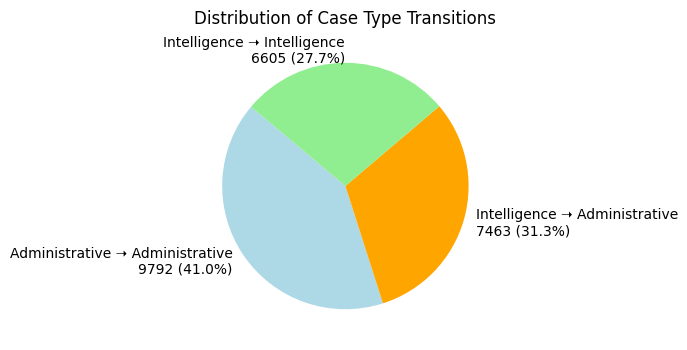

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# חישוב ההתפלגות של המעברים בין סוגי התיקים
case_transitions = merged.groupby(["Type_1", "Type_2"]).size().reset_index(name="Count")

# חישוב האחוזים
total_cases = case_transitions["Count"].sum()
case_transitions["Percentage"] = (case_transitions["Count"] / total_cases) * 100

# יצירת תוויות לגרף
labels = [f"{row['Type_1']} ➝ {row['Type_2']}\n{row['Count']} ({row['Percentage']:.1f}%)" for _, row in case_transitions.iterrows()]

# יצירת גרף עוגה
plt.figure(figsize=(4,4))
plt.pie(case_transitions["Count"], labels=labels, autopct="", startangle=140, colors=["lightblue", "orange", "lightgreen", "red", "purple"])
plt.title("Distribution of Case Type Transitions")
plt.show()


כרגע לא ראינו צטורך לאזן את הדאטה יותר מזה כי אנו מקוות שהמודל יהיה בעל אחוז גבוה יותר של הצלחה.

נוסיף עמודה האם התיק הפך ממודיעיני למנהלי

In [ ]:
import numpy as np

# הוספת עמודה intelligence_to_administrative לאחר האיחוד (ללא lower)
merged["intelligence_to_administrative"] = np.where(
    (merged["Type_1"] == "Intelligence") & (merged["Type_2"] == "Administrative"),
    "Yes",
    "No"
)


כיוון שהמודל צריך להבין האם היה שינוי ממודיעיני למנהלי, עדיף ליצור את 2 עמודות חדשות, העמודות האלו יקבל ערך 1 כאשר סוג העבירה נשאר אותו דבר לפי שמם (מנהלי נשאר מנהלי), וכאשר לא אז 0
היתרון כאן הוא שזה מאפשר לנתח מגמות מעבר בצורה ישירה, ולא רק לבסס את ההסקה על השוואה בין שני משתנים קיימים.


In [ ]:
merged['intelligence_to_intelligence'] = ((merged['Type_1'] == 'Intelligence') & (merged['Type_2'] == 'Intelligence')).astype(int)
merged['administrative_to_administrative'] = ((merged['Type_1'] == 'Administrative') & (merged['Type_2'] == 'Administrative')).astype(int)
#לאחר הקוד הזה כל עמודה מתארת מצב של תיק וערך בה הוא אחד כאשר זה מצב התיק

עכשיו נתחיל בהעברת כל המידע לערכים בהם נוכל להריץ עליהם מודלים.

In [ ]:
#@title  קל-קשיח, אזור עירוני, אזור יהודי ומסוגי התיקים לבינארי
# שינוי הערכים בעמודות Kal_Kashiah_1 ו-Kal_Kashiah_2
merged_df=merged.copy()
merged_df[['Kal_Kashiah_1', 'Kal_Kashiah_2']] = merged_df[['Kal_Kashiah_1', 'Kal_Kashiah_2']].replace({'hard': 1, 'easy': 0})
merged_df[['city_erea',	'jewish_e',	'intelligence_to_administrative','intelligence_to_intelligence','administrative_to_administrative']] = merged_df[['city_erea',	'jewish_e',	'intelligence_to_administrative','intelligence_to_intelligence','administrative_to_administrative']].replace({'Yes': 1, 'No': 0})

<ipython-input-54-08ae75b32756>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df[['Kal_Kashiah_1', 'Kal_Kashiah_2']] = merged_df[['Kal_Kashiah_1', 'Kal_Kashiah_2']].replace({'hard': 1, 'easy': 0})
<ipython-input-54-08ae75b32756>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df[['city_erea',	'jewish_e',	'intelligence_to_administrative','intelligence_to_intelligence','administrative_to_administrative']] = merged_df[['city_erea',	'jewish_e',	'intelligence_to_administrative','intelligence_to_intelligence','administ

In [ ]:
# @title מחוזות לבינארי
merged_df = pd.get_dummies(merged_df, columns=["District"], dtype=int)

In [ ]:
#@title רבעונים לבינארי


# יצירת One-Hot Encoding עבור Potential_Type_Grouped
merged_df = pd.get_dummies(merged_df, columns=["Quarter_Update_1"], dtype=int)
merged_df = pd.get_dummies(merged_df, columns=["Quarter_Update_2"], dtype=int)


### אופי איתור
כן, החלוקה שהצעתי מתחשבת גם באיזון ההתפלגות, אבל לא באופן מוחלט. היא משלבת בין שיקולים של משמעות הנתונים לבין שיקולים של איזון סביר.
הנה כמה נקודות חשובות:
 * שיקולי משמעות ראשונים:
   * התחלתי בניתוח המשמעות של כל ערך, וחיפשתי קבוצות טבעיות של ערכים שמתקשרים זה לזה.
   * זה אומר שקבוצות כמו "בנייה בשלבים" ו"מבנים" נוצרו בגלל הקשר ההגיוני בין הערכים, ולא רק בגלל גודלן.
 * התחשבות בהתפלגות:
   * לאחר יצירת הקבוצות המשמעותיות, בדקתי את גודלן.
   * ניסיתי להימנע מיצירת קבוצות קטנות מדי, שעלולות לגרום להטיות במודל.
   * עם זאת, לא ניסיתי ליצור איזון מוחלט, מכיוון שזה עלול לפגוע במשמעות הנתונים.
 * פשרה:
   * החלוקה היא פשרה בין משמעות להתפלגות.
   * אני מאמין שהיא מספקת איזון סביר, תוך שמירה על המשמעות הטבעית של הנתונים.
לסיכום, החלוקה שואפת לאיזון סביר, אך לא מוחלט, תוך מתן עדיפות למשמעות הנתונים.

In [ ]:
# יצירת מיפוי קטגוריות בצורה מסודרת יותר
category_mapping = {
    **dict.fromkeys([
        "Land preparation for construction",
        "Skeleton in advanced construction",
        "concrete floor",
        "skeleton at the beginning of construction",
        "skeleton structure",
        "skeleton in a dissertation",
        "Drilling foundations",
        "base for columns",
        "End of construction"
    ], "Construction Stages"),

    **dict.fromkeys([
        "sheds",
        "structure",
        "Mobile structure",
        "pen",
        "pier",
        "deck",
        "change to mobile structure"
    ], "Buildings"),

    **dict.fromkeys([
        "Dirt roads or road paving",
        "Infrastructure for a permanent/temporary structure",
        "Dirt"
    ], "Infrastructure and Roads"),

    **dict.fromkeys([
        "fence",
        "shading net"
    ], "Fences and Nets"),

    **dict.fromkeys([
        "Extra construction",
        "collection of construction materials",
        "new floor",
        "destroyed",
        "Solar panels"
    ], "Other")
}

# המרת הנתונים לקטגוריות המאוחדות עבור שתי העמודות
merged_df["Potential_Type_1_Grouped"] = merged_df["Potential_Type_1"].map(category_mapping)
merged_df["Potential_Type_2_Grouped"] = merged_df["Potential_Type_2"].map(category_mapping)


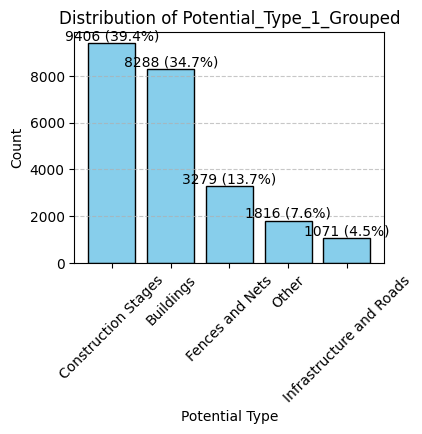

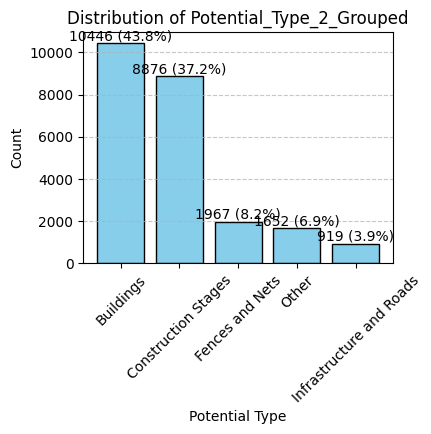

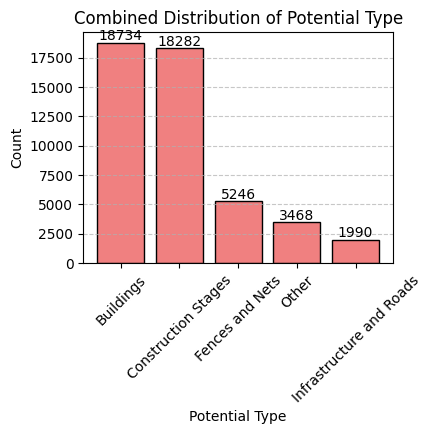

In [ ]:
# ניתוח התפלגות Potential_Type
for col in ["Potential_Type_1_Grouped", "Potential_Type_2_Grouped"]:
    potential_type_counts = merged_df[col].value_counts()
    total_count = potential_type_counts.sum()
    percentages = (potential_type_counts / total_count) * 100

    # יצירת גרף
    plt.figure(figsize=(4, 3))
    bars = plt.bar(potential_type_counts.index, potential_type_counts, color='skyblue', edgecolor='black')
    for bar, count, percent in zip(bars, potential_type_counts, percentages):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 f"{count} ({percent:.1f}%)", ha='center', va='bottom', fontsize=10, color='black')
    plt.xlabel("Potential Type")
    plt.ylabel("Count")
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# איחוד ההתפלגות של שתי העמודות
merged_potential_types = pd.concat([
    merged_df["Potential_Type_1_Grouped"],
    merged_df["Potential_Type_2_Grouped"]
]).value_counts()

# גרף של ההתפלגות המאוחדת
plt.figure(figsize=(4, 3))
bars = plt.bar(merged_potential_types.index, merged_potential_types, color='lightcoral', edgecolor='black')
for bar, count in zip(bars, merged_potential_types):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{count}", ha='center', va='bottom', fontsize=10, color='black')
plt.xlabel("Potential Type")
plt.ylabel("Count")
plt.title("Combined Distribution of Potential Type")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# @title איחוד לפי היגיון של ערכי יעוד קרקע מחוזי

land_category_mapping = {
    ('Agricultural park', 'Agriculture and industry', 'Agricultural area/ open countryside', 'Special agricultural area', 'Agricultural land and pasture', 'Protected open/agricultural area', 'Agricultural countryside landscape area', 'Integrated agricultural rural landscape area'): 'Agricultural area',

    ('Open areas', 'Open Space', 'Special open area', 'Urban open area', 'Area for planning in the future - open areas', 'Road area', 'road', 'Open area',
     'National Park', 'National Garden', 'National Garden ', 'Reserve area for planning', 'Nature reserve', 'Nature reserve ', 'Nof Reserve', 'Area for scenic and visual restoration', 'Area for conservation of natural resources and landscape', 'Forest', 'A forest planted by a man', 'A natural forest', 'Natural forest for conservation', 'A natural forest for cultivation', 'forest park', 'Coastal Park Forest', 'A forest within a development area', 'Forest Park exist', 'Forest ', 'forest ', 'forest',
     'A public garden park with special instructions', 'Public garden park', 'Park', 'Metropolitan Park'): 'Nature & Conservation'	,

    ('An area of גÄãגÄãimportance to the metropolis', 'Integrated metropolitan area', 'Metropolitan recreation area', 'Urban development area', 'urban', 'Urban settlement', 'an area for urban development', 'An integrated suburban settlement', 'Suburban development area', 'An area of \u200b\u200bimportance to the metropolis',
    'Residence', 'residences and public institutions', 'Living area', 'Living area '): 'Urban & Residential',

    ('Industrial Area', 'Industrial Area ', 'industry', 'Kadmat Negev industrial area', 'Ramat Beka Industrial Zone', 'National industrial zone', 'Industry and craft', 'Industrial craft and employment area',
    'Spatial employment area', 'Secondary metropolitan employment area', 'employment area', 'Employment Center ', 'Main business center', 'Employment and public buildings', 'trade and tourism', 'Commerce and offices', 'Commerce, residence and institution', 'Commerce, residential and industrial', 'Commercial and residential', 'Commerce, employment and transportation'): 'Industrial & Employment',

    ('Tourism', 'tourism', 'Extensive recreation area', 'tourism and public institutions', 'Tourist area', 'Tourist park',
    'trade and public institutions', 'institution(Other)', 'Public buildings and institutions with special instructions', 'public institutions', 'institution', 'Public buildings and institutions'): 'Tourism & Commerce',

    ('beach', 'Beach', 'River', 'Protected beach', 'Kinneret Beach Area ','Nahal area and its surroundings', 'Planting on nahalim', 'the banks of the streams', 'river '): 'Beach/ River ',

    ('Village', 'Vilage', 'Village development area'): 'Village',

    ('Mining and construction that overlaps Tama areas', 'engineering facilities', 'Sport', 'transportation', 'Hotels', 'Desert landscape area', 'Other', 'Nevatim Airport', 'Airport', 'Cemetery', 'cemeteries', 'Area for pooling the introduction and utilization of surface water', 'Land for a mining site', 'Quarrying area, mining and rehabilitation', 'quarry site', 'Mining and quarrying', 'Mining and quarrying area', 'Exploration area for mining and quarrying',
     '---', 'Unknown District land designation', 'Area with no defined purpose'): 'Unknown & Other',
}

# החלת המיפוי על הנתונים
# החלת המיפוי על הנתונים באמצעות פונקציה מותאמת אישית
def map_land_category(value):
    for keys, new_value in land_category_mapping.items():
        if value in keys:
            return new_value
    return value  # במקרה ואין התאמה, מחזירים את הערך המקורי

# החלת הפונקציה על עמודת 'District_land_designation'
merged_df['District_land_designation'] = merged_df['District_land_designation'].apply(map_land_category)

In [ ]:
pd.set_option('display.max_rows', None)  # הצגת כל השורות

# חישוב שכיחויות ואחוזים עבור העמודה 'District_land_designation'
value_counts = merged_df['District_land_designation'].value_counts().reset_index()
value_counts.columns = ['District_land_designation', 'Count']

# חישוב אחוזים
total_count = value_counts['Count'].sum()
value_counts['Percentage'] = (value_counts['Count'] / total_count) * 100

In [ ]:
# יצירת One-Hot Encoding עבור Potential_Type_Grouped
merged_df = pd.get_dummies(merged_df, columns=["Potential_Type_1_Grouped"], dtype=int)
merged_df = pd.get_dummies(merged_df, columns=["Potential_Type_2_Grouped"], dtype=int)
merged_df = pd.get_dummies(merged_df, columns=["District_land_designation"], dtype=int)
merged_df.head(10)

,Case,Year_1,Year_2,Update_Photo_Date_1,Update_Photo_Date_2,Type_1,Type_2,Potential_Type_1,Potential_Type_2,Kal_Kashiah_1,Kal_Kashiah_2,Planning_Area,Local_Authority,City,Block,Parcel,X_1,X_2,Y_1,Y_2,Local_land_designation,Prevantion,Defence,Vatmal,Tzvir,Return,city_erea,jewish_e,intelligence_to_administrative,intelligence_to_intelligence,administrative_to_administrative,District_Center,District_Jerusalem,District_North,District_South,Quarter_Update_1_Q1,Quarter_Update_1_Q2,Quarter_Update_1_Q3,Quarter_Update_1_Q4,Quarter_Update_2_Q1,Quarter_Update_2_Q2,Quarter_Update_2_Q3,Quarter_Update_2_Q4,Potential_Type_1_Grouped_Buildings,Potential_Type_1_Grouped_Construction Stages,Potential_Type_1_Grouped_Fences and Nets,Potential_Type_1_Grouped_Infrastructure and Roads,Potential_Type_1_Grouped_Other,Potential_Type_2_Grouped_Buildings,Potential_Type_2_Grouped_Construction Stages,Potential_Type_2_Grouped_Fences and Nets,Potential_Type_2_Grouped_Infrastructure and Roads,Potential_Type_2_Grouped_Other,District_land_designation_Agricultural area,District_land_designation_Beach/ River,District_land_designation_Industrial & Employment,District_land_designation_Nature & Conservation,District_land_designation_Tourism & Commerce,District_land_designation_Unknown & Other,District_land_designation_Urban & Residential,District_land_designation_Village
0,100000_NEW_0,2022,2022,2022-03-06,2022-06-23,Intelligence,Intelligence,collection of construction materials,shading net,0,0,Tira,Tira,Tire,7767.0,20.0,197933.0,197933.0,682467.0,682466.0,Agricultural land and pasture,Yes,No,No,NaN,No,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
1,100001_NEW_0,2022,2022,2022-01-03,2022-08-01,Administrative,Administrative,Skeleton in advanced construction,Skeleton in advanced construction,1,1,Taybe,Taybe,Tayibe,7831.0,91.0,198318.0,198317.0,684952.0,684953.0,Open areas,Yes,No,No,NaN,No,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,100003_NEW_0,2022,2022,2022-07-19,2022-12-08,Administrative,Administrative,Skeleton in advanced construction,Skeleton in advanced construction,1,1,Ma'ale Hagalil,Kasra-Samiya,Kisra-Sumei,19228.0,20.0,228317.0,228318.0,763602.0,763602.0,NaN,Yes,Yes,No,NaN,No,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
3,100004_NEW_0,2021,2022,2021-08-04,2022-08-28,Intelligence,Intelligence,sheds,shading net,0,0,Jerusalem,Jerusalem,Jerusalem,NaN,NaN,222984.0,222983.0,625944.0,625944.0,Open areas,No,No,No,NaN,No,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,100005_NEW_0,2022,2022,2022-09-12,2022-11-11,Administrative,Administrative,new floor,new floor,1,1,Jerusalem,Jerusalem,Jerusalem,30571.0,3.0,223895.0,223895.0,635310.0,635309.0,---,No,No,No,NaN,No,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
5,100006_NEW_0,2021,2021,2021-08-19,2021-12-27,Administrative,Administrative,Skeleton in advanced construction,Skeleton in advanced construction,1,1,Eiron,Umm al-Fahm,Umm Al-Fahm,20308.0,36.0,217019.0,217019.0,714867.0,714867.0,Agricultural land and pasture,No,No,No,NaN,No,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
6,100008_NEW_0,2021,2021,2021-10-01,2021-11-05,Administrative,Administrative,sheds,sheds,0,0,Lod,Lod,Lod,NaN,NaN,190739.0,190739.0,651680.0,651681.0,Residence,No,No,No,NaN,No,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
7,100009_NEW_0,2017,2017,2017-02-18,2017-02-18,Administrative,Administrative,Mobile structure,Mobile structure,0,0,Gvaot Alonim,Shfaram,Shefar'am,10266.0,24.0,215514.0,215514.0,748128.0,748128.0,NaN,No,No,No,NaN,No,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
8,10000_NEW_0,2017,2018,2017-10-27,2018-09-01,Intelligence,Intelligence,Land preparation for construction,Land preparation for construction,1,1,Lev Hagalil,Sachnin,Sakhnin,19272.0,7.0,227692.0,227697.0,753326.0,753322.0,NaN,No,No,No,NaN,No,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,

עמודות שנה, תיק, גוש וחלקה, קורדינאטות, מרחבי אכיפה - כרגע לא ראינו בהם משהו שיכול להשפיע על המודל אז לא הוספנו אותם

# עד לפה הגשת אמצע.
# **הקובץ המעודכן נשמר בשם merged_df ומעכשיו נריץ הכל בקולב חדש **

מה שמפה למטה לא רלוונטי

**ניתוח והתאמת האלגוריתמים לדאטה**

הדאטה מכיל משתנים קטגוריאליים (כגון סוג, מחוז, יעוד קרקע וכו') ומספריים (כגון קורדינטות, שנים וכו'), והמטרה היא לסווג האם עבירה מודיעינית תהפוך למנהלית (intelligence_to_administrative). בהתבסס על מבנה הנתונים, כל אחד מהאלגוריתמים הבאים מתאים לשימוש בפרויקט:

1. Logistic Regression
למה נכון להשתמש בו?

מתאים לבעיות סיווג בינארי, כמו המקרה שלנו (האם העבירה תהפוך למנהלית או לא).
קל לפרש את התוצאות, מאפשר להבין אילו תכונות משפיעות יותר על הסיווג.
מניח תלות לינארית בין המשתנים לבין הסבירות של היעד, מה שעשוי להיות נכון עבור חלק מהמאפיינים.
מגבלות:

לא מתאים אם הנתונים אינם נפרדים בצורה ליניארית.
רגיש לערכים חריגים.
2. Support Vector Machine (SVC)
למה נכון להשתמש בו?

חזק במיוחד במקרים של מרחב מאפיינים רב-ממדי, כפי שיש לנו בדאטה.
ניתן להשתמש ב-kernels שונים כדי להתאים גם לבעיות לא ליניאריות.
עובד טוב עם דגימות קטנות יחסית, בתנאי שהמימדיות לא גבוהה מאוד.
מגבלות:

מורכב ויכול להיות איטי על דאטה גדול.
פחות אינטרפרטבילי בהשוואה לרגרסיה לוגיסטית.
3. Random Forest (עצי החלטה מרובים)
למה נכון להשתמש בו?

מתאים לבעיות סיווג מורכבות עם יחסים לא לינאריים.
אינו רגיש לערכים חריגים ולחוסר לינאריות בנתונים.
מספק אינדיקציה על החשיבות של כל מאפיין, דבר שיכול לעזור להבין מה משפיע יותר.
מגבלות:

יכול להיות כבד מבחינת חישובים, במיוחד עם מספר גדול של עצים.
פחות אינטואיטיבי להבנה לעומת מודלים פשוטים יותר.
4. Neural Network (רשת נוירונים)
למה נכון להשתמש בו?

יכול לזהות קשרים מורכבים מאוד בנתונים שלא ניתן לגלות עם שיטות קלאסיות.
מתאים כאשר יש הרבה נתונים, מה שעוזר למודל ללמוד תבניות נסתרות.
מגבלות:

דורש זמן חישוב רב יחסית.
קשה יותר לפרש את התוצאות לעומת מודלים פשוטים יותר.
דורש כוונון מדויק של הפרמטרים כדי להשיג ביצועים טובים.
5. K-Nearest Neighbors (KNN)
למה נכון להשתמש בו?

פשוט להבנה וליישום.
לא מניח הנחות על צורת ההתפלגות של הנתונים.
מתאים כאשר הנתונים ניתנים להפרדה על פי מרחקים במרחב.
מגבלות:

יכול להיות איטי מאוד כאשר יש הרבה דוגמאות.
מושפע מאוד מבחירת הפרמטר K והמרחקים בין הנתונים.
רגיש לרעש ולמאפיינים לא רלוונטיים.
סיכום
לנתונים עם תלות ליניארית: Logistic Regression.
כאשר הנתונים מורכבים ולא ליניאריים: SVM או Random Forest.
כאשר רוצים גמישות ודיוק גבוהים על חשבון פרשנות: Neural Network.
כאשר הנתונים מקובצים לפי דמיון וללא הנחות מוקדמות: KNN.
בהתאם לביצועים בפועל, ניתן יהיה לבחור את האלגוריתם הטוב ביותר על ידי ניסויים ובדיקת מדדים כמו דיוק (Accuracy), רגישות (Recall) וספציפיות (Precision).

אולי אפר לעשות גם Multilayer Perceptron (MLP)

נעשה זאת לפי סדר העמודות
               Case נתעלם ממנו כשנריץ את המודל כי כל רשומה מייצגת תיק.
               Year_1 אין השפעה על העיר על הסיכוי של תיק להפוך ממודיעני למנהלי נתעלם גם מהעמודות השנים.
               Year_2
               Update_Photo_Date_1  השתמשנו ברבעונים
               Update_Photo_Date_2
               District מחוזות. המרנו לבינארי.
               Type_1 הפכנו לבינארי- כל מה שמודיעני מקבל אפס לתת כותרת חדשה
               Type_2כל מה שמודיעני מקבל אפס                              Potential_Type_1 איחדנו קטגוריות והמרנו לבינארי                             
               Potential_Type_2
               Kal_Kashiah_1  מה שיש לו hard הפכנו לאחד
               Kal_Kashiah_2 מה שיש לו easy הפכנו לאפס
               Planning_Area קיבל התייחסות במחוזות. נתעלם
               Local_Authority כנל
               City כנל
               Block סידרנו
               Parcel
               X_1
               X_2
               Y_1
               Y_2
               District_land_designation איחוד קטגוריות והמרה לבינארי
               Local_land_designation נתייחס רק למחוזי
               Prevantion Defence Vatmal Tzvir Return- הגדרות של הרשות לאזורים מסויים להחלטה איך לאכוף אותם אז לא קשור מודל שלנו
               Quarter_Update_1 , זה הרבעונים - עשינו בעיר
               Quarter_Update_2
               city_erea האם עירוני או לא. עיר יקבל אחד. לא עיר מקבל אפס.
               רשות מקומית מועצה וכו
               jewish_e האם השטח של יהודים או לא. yes יקבל אחד
               intelligence_to_administrative - כן מקבל אחד, לא מקבל 0


##איך נסדר את העמודות במודלים
**בטוח ואותו דבר על כל מודל:**
*   קל קשיח
*   אזור עירוני
* אזור יהודי
* מודיעיני לנמהלי
* מנהלי למנהלי
* מודיעיני למודיני

**בטוח ושונה לכל מודל**
*   מחוזות
* פוטנשיאל טייפ
* יעוד קרקע מחוזי


**לראות השפעה על כל מודל:**
* רבעונים - אולי בכלל יהיה עדיף לעשות חודשים
* עמודות זמנים - שנה רבעונים והפרש רבעונים
* גוש וחלקה
* קורדינאטות


**הסרה של עמודות:**
*   טייפ
*   מספר תיק
* תאריכים מדויייקים
* יעוד קרקע מקומי
* Prevantion Defence Vatmal Tzvir Return




לגבי עמודת הזמן - השנה והרבעונים- נבדוק את הקורלציה ואת ההשפעה על חמשת המודלים  בין השנים, בין הפרש השנים והפרש הרבעונים לבין שינוי סוג העבירה ונראה האם יש מגמה מסויימת

In [ ]:

# חישוב מספר הרבעונים שעברו בין שתי העבירות
merged['Δ_Quarter'] = (merged['Year_2'] - merged['Year_1']) * 4 + (merged['Quarter_2_Num'] - merged['Quarter_1_Num'])

# הצגת סטטיסטיקות של ההפרשים
print(merged['Δ_Quarter'].describe())


In [ ]:
#@title קורלציה עמודות זמן
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# חישוב קורלציה עם משתנה המטרה
correlation_values = merged[['Year_1', 'Year_2']].corrwith(merged['intelligence_to_administrative'])

# חישוב הפרש השנים והרבעונים
merged['Δ_Year'] = merged['Year_2'] - merged['Year_1']
merged['Δ_Quarter'] = (merged['Year_2'] - merged['Year_1']) * 4 + (merged['Quarter_2_Num'] - merged['Quarter_1_Num'])

# חישוב קורלציה עבור Δ_Year ו- Δ_Quarter
correlation_values['Δ_Year'] = merged[['Δ_Year']].corrwith(merged['intelligence_to_administrative'])['Δ_Year']
correlation_values['Δ_Quarter'] = merged[['Δ_Quarter']].corrwith(merged['intelligence_to_administrative'])['Δ_Quarter']

# הדפסת התוצאות
print("📌 קורלציה בין המשתנים למעבר לעבירה מנהלית:")
print(correlation_values)
print(" קורלציה בין משתני הזמן למעבר עבירה ממודיעינית למנהלית")
# יצירת גרף להצגה בדוח
plt.figure(figsize=(5, 3))
sns.barplot(x=correlation_values.index, y=correlation_values.values, palette='coolwarm')
plt.xlabel("Feature")
plt.ylabel("Correlation with Target")
plt.title("Correlation between Features and Target")
plt.ylim(0, 0.1)  # ציר Y מתחיל מ-0

# הצגת ערכים על כל עמודה
for i, v in enumerate(correlation_values.values):
    plt.text(i, v + 0.002, f"{v:.4f}", ha='center', fontsize=10)

plt.show()


In [ ]:
#@title חשיבות עמודות הזמן ב SVM
from sklearn.svm import SVC

# בחירת משתנים מספריים בלבד (כולל Δ_Quarter)
X = merged[['Year_1', 'Year_2', 'Δ_Year', 'Δ_Quarter']].select_dtypes(include=['number'])
y = merged['intelligence_to_administrative']

# אימון SVM עם משתני הזמן
svm = SVC(kernel='linear')
svm.fit(X, y)

print("🔹 חשיבות עמודות הזמן במודל SVM")
coef = svm.coef_[0]
for feature, weight in zip(X.columns, coef):
    print(f"✅ {feature}: {weight:.6f}")

# אימון SVM ללא משתני הזמן
X_no_time = merged.drop(columns=['Year_1', 'Year_2', 'Δ_Year', 'Δ_Quarter'], errors='ignore')

# השארת רק משתנים מספריים
X_no_time = X_no_time.select_dtypes(include=['number'])

# **פתרון 1: מילוי NaN בערכים ממוצעים**
X_no_time = X_no_time.fillna(X_no_time.mean())

# **פתרון 2: הסרת שורות עם NaN (אם רוצים להסיר)**
# X_no_time = X_no_time.dropna()


In [ ]:
#@title חשיבות עמודות הזמן ב-KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# בחירת משתנים, כולל Δ_Quarter
X = merged[['Year_1', 'Year_2', 'Δ_Year', 'Δ_Quarter']]
y = merged['intelligence_to_administrative']

# חלוקת נתונים
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN עם כל המשתנים
knn1 = KNeighborsClassifier(n_neighbors=5)
knn1.fit(X_train, y_train)
y_pred1 = knn1.predict(X_test)
accuracy_with_years = accuracy_score(y_test, y_pred1)

# KNN רק עם Δ_Year
X_train2, X_test2 = X_train[['Δ_Year']], X_test[['Δ_Year']]
knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(X_train2, y_train)
y_pred2 = knn2.predict(X_test2)
accuracy_with_delta = accuracy_score(y_test, y_pred2)

# KNN רק עם Δ_Quarter
X_train3, X_test3 = X_train[['Δ_Quarter']], X_test[['Δ_Quarter']]
knn3 = KNeighborsClassifier(n_neighbors=5)
knn3.fit(X_train3, y_train)
y_pred3 = knn3.predict(X_test3)
accuracy_with_quarter = accuracy_score(y_test, y_pred3)

# הדפסת התוצאות בצורה מסודרת
print("🔹 חשיבות עמודות הזמן במודל KNN")
print(f"✅ דיוק עם Year_1, Year_2, Δ_Year: {accuracy_with_years:.4f}")
print(f"✅ דיוק רק עם Δ_Year: {accuracy_with_delta:.4f}")
print(f"✅ דיוק רק עם Δ_Quarter: {accuracy_with_quarter:.4f}")


In [ ]:
#@title חשיבות עמודות הזמן ב- Neural Network (MLPClassifier)
from sklearn.neural_network import MLPClassifier

# NN עם כל המשתנים
nn1 = MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
nn1.fit(X_train, y_train)
accuracy_nn_with_years = nn1.score(X_test, y_test)

# NN רק עם Δ_Year
nn2 = MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
nn2.fit(X_train2, y_train)
accuracy_nn_with_delta = nn2.score(X_test2, y_test)

# NN רק עם Δ_Quarter
X_train3, X_test3 = X_train[['Δ_Quarter']], X_test[['Δ_Quarter']]
nn3 = MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
nn3.fit(X_train3, y_train)
accuracy_nn_with_quarter = nn3.score(X_test3, y_test)



In [ ]:
#@title חשיבות עמודות הזמן ב- Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# בחירת משתנים, כולל Δ_Quarter
X = merged[['Year_1', 'Year_2', 'Δ_Year', 'Δ_Quarter']]
y = merged['intelligence_to_administrative']

# חלוקת הנתונים
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# יצירת מודל Random Forest עם משתני הזמן
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# הצגת חשיבות המאפיינים
importances = rf.feature_importances_
print("🔹 חשיבות עמודות הזמן במודל Random Forest")
for feature, importance in zip(X.columns, importances):
    print(f"✅ {feature}: {importance:.6f}")

In [ ]:
#@title חשיבות עמודות הזמן ב LR
from sklearn.linear_model import LogisticRegression

# בחירת משתנים, כולל Δ_Quarter
X = merged[['Year_1', 'Year_2', 'Δ_Year', 'Δ_Quarter']]
y = merged['intelligence_to_administrative']

# אימון Logistic Regression
lr = LogisticRegression()
lr.fit(X, y)
print("חשיבות עמודות הזמן ב LR")
# הצגת המקדמים
coef = lr.coef_[0]
for feature, weight in zip(X.columns, coef):
    print(f"{feature}: {weight:.6f}")

In [ ]:
# NN בלי משתני הזמן בכלל
nn4 = MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
nn4.fit(X_train.drop(columns=['Δ_Year', 'Δ_Quarter'], errors='ignore'), y_train)
accuracy_nn_without_any = nn4.score(X_test.drop(columns=['Δ_Year', 'Δ_Quarter'], errors='ignore'), y_test)

print(f"✅ דיוק NN בלי משתני זמן כלל: {accuracy_nn_without_any:.4f}")


In [ ]:
from sklearn.metrics import accuracy_score

# LR בלי Δ_Year
lr2 = LogisticRegression()
lr2.fit(X_train.drop(columns=['Δ_Year'], errors='ignore'), y_train)
y_pred_lr2 = lr2.predict(X_test.drop(columns=['Δ_Year'], errors='ignore'))
accuracy_lr_without_year = accuracy_score(y_test, y_pred_lr2)

print(f"✅ דיוק LR בלי Δ_Year: {accuracy_lr_without_year:.4f}")


לאחר בדיקות סטטיסטיות ובדיקות אימון מודלים, נמצא כי החשיבות של Year_1, Year_2, ו- Δ_Year משתנה בהתאם לסוג המודל.
1️⃣ ב-Random Forest, Δ_Quarter נמצא כמשתנה החשוב ביותר (0.7491), ולכן נשמור אותו ונוריד את Δ_Year.
2️⃣ ב-KNN, Δ_Quarter משפר את הדיוק משמעותית לעומת Δ_Year, ולכן נשמור רק אותו.
3️⃣ ב-Logistic Regression, Δ_Year משפיע מעט יותר מיתר המשתנים, ולכן נשמור רק אותו.
4️⃣ ב-SVM וברשתות נוירונים (NN), אף אחד מהמשתנים הללו לא תרם משמעותית ולכן נסיר אותם מהמודלים הללו.

המסקנה הכללית: Δ_Quarter עדיף על Δ_Year, ולכן נשתמש בו במודלים שבהם הוא משמעותי (RF ו-KNN), ונוריד את כל יתר המשתנים שאינם מועילים.

In [ ]:

# המרת הרבעונים לערכים מספריים (Q1=1, Q2=2, Q3=3, Q4=4)
quarter_mapping = {'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4}
df['Quarter_1_Num'] = df['Quarter_Update_1'].map(quarter_mapping)
df['Quarter_2_Num'] = df['Quarter_Update_2'].map(quarter_mapping)

# חישוב מספר הרבעונים שעברו בין שתי העבירות
df['Δ_Quarter'] = (df['Year_2'] - df['Year_1']) * 4 + (df['Quarter_2_Num'] - df['Quarter_1_Num'])

# חישוב הפרש השנים
df['Δ_Year'] = df['Year_2'] - df['Year_1']

# יצירת גרסאות נפרדות לכל מודל בהתאם למסקנות
df_rf = df[['Δ_Quarter', 'intelligence_to_administrative']].copy()  # עבור Random Forest
df_lr = df[['Δ_Year', 'intelligence_to_administrative']].copy()  # עבור Logistic Regression
df_svm = df[['intelligence_to_administrative']].copy()  # SVM - ללא המשתנים האלו
df_knn = df[['Δ_Quarter', 'intelligence_to_administrative']].copy()  # עבור KNN
df_nn = df[['intelligence_to_administrative']].copy()  # Neural Network - ללא המשתנים האלו

# הצגת הודעה שהעיבוד הסתיים
print("✔️ הדאטה הוכן לכל אחד מהמודלים בהתאם למסקנות.")
print(f"🔹 df_rf (Random Forest) - {df_rf.shape}")
print(f"🔹 df_lr (Logistic Regression) - {df_lr.shape}")
print(f"🔹 df_svm (SVM) - {df_svm.shape}")
print(f"🔹 df_knn (KNN) - {df_knn.shape}")
print(f"🔹 df_nn (Neural Network) - {df_nn.shape}")


In [ ]:
# המרת העמודות Year_1 ו-Year_2 לערכים מספריים
merged_df = merged.copy()
merged_df['Year_1'] = pd.to_numeric(merged_df['Year_1'], errors='coerce')
merged_df['Year_2'] = pd.to_numeric(merged_df['Year_2'], errors='coerce')

print("התפלגות סוגי האיתורים לפי שנה")

# הכנת הנתונים לגרף אחד
melted_df = merged_df.melt(id_vars=['Year_1', 'Year_2'], value_vars=['Type_1', 'Type_2'],
                           var_name='Type_Column', value_name='Type')
melted_df = melted_df.melt(id_vars=['Type'], value_vars=['Year_1', 'Year_2'], var_name='Year_Column', value_name='Year')

# בדיקת הקשר בין השנה לבין סוג האיתור (מודיעיני/מנהלי)
plt.figure(figsize=(6, 3))
sns.countplot(data=melted_df.dropna(), x='Year', hue='Type', order=sorted(melted_df['Year'].dropna().unique()))
plt.title("Distribution of types of detections by year")
plt.xlabel("Year")
plt.ylabel("Number of cases")
plt.xticks(rotation=45)
plt.show()

# חישוב שינוי בסוג העבירה (אם עבר ממודיעיני למנהלי או להפך)
merged_df["Type_Change"] = merged_df.apply(lambda row: 1 if row["Type_1"].lower() != row["Type_2"].lower() else 0, axis=1)

# בדיקת מתאם בין השנים לבין שינוי בסוג העבירה
df_numeric = merged_df[['Year_1', 'Year_2', 'Type_Change']].copy()

# חישוב מתאם
correlation = df_numeric.corr()
print("Correlation matrix between years and type change:")
print(correlation)


2. Year_1 ו-Type_Change (0.013569)
🔹 מתאם חלש מאוד → אין קשר משמעותי בין השנה הראשונה לבין שינוי בסוג העבירה.
🔹 כלומר, העובדה שתיק התרחש מוקדם או מאוחר לא משפיעה על הסבירות שהסוג השתנה.

3. Year_2 ו-Type_Change (0.040976)
🔹 גם כאן מתאם חלש מאוד → אין קשר חזק בין השנה השנייה לבין שינוי הסוג.
🔹 כלומר, השנה שבה מתבצע האיתור השני אינה מנבאת את שינוי הסוג.

מה אפשר להסיק מזה?
📌 שינוי בסוג העבירה לא תלוי בשנה – כלומר, מעבר ממודיעיני למנהלי (או להיפך) לא נפוץ יותר בשנים מסוימות.
📌 השנים קשורות זו לזו – תיקים שבהם יש שתי רשומות נוטים להתרחש בשנים קרובות.
📌 אם רצית לבדוק האם השנים משפיעות על שינוי הסוג – התשובה היא לא (לפחות לפי המתאם כאן).

לגבי עמודות התאריכים - אנו נסתכל עליהם, בהתחלה לפחות, לפי חלוקה לרבעונים. הוספנו כבר עמודת רבעונים לפי התאריך ועכשיו את 2 עמודות הרבעונים (Quarter_Update_1 ו Quarter_Update_2) נמיר כל אחת מהן ל4 עמודות בינאריות

In [ ]:
בבה

טיפול בעמודות גוש חלקה

In [ ]:
# המרת הערכים למחרוזת, הוספת אפסים מובילים, ואם התא ריק - לשים "unknown"
Offenses_Data["Block"] = Offenses_Data["Block"].apply(lambda x: str(int(x)).zfill(4) if pd.notna(x) else "unknown")
Offenses_Data["Parcel"] = Offenses_Data["Parcel"].apply(lambda x: str(int(x)).zfill(3) if pd.notna(x) else "unknown")

# הדפסת התוצאה
print(Offenses_Data)

In [ ]:
print(f"X Min: {merged_df['X_1'].min()}, X Max: {merged_df['X_1'].max()}")
print(f"Y Min: {merged_df['Y_1'].min()}, Y Max: {merged_df['Y_1'].max()}")


נורמליזציה (Min-Max Scaling) לא משנה את המיקום היחסי

כל הערכים יומרו לטווח [0,1] על ידי הנוסחה:
𝑋norm=(𝑋−𝑋min⁡)/(𝑋max⁡−𝑋min⁡)

זה אומר שהנקודה עם X הכי קטן תהיה 0, והנקודה עם X הכי גדול תהיה 1.
כל הערכים באמצע יישארו פרופורציונליים! כלומר, אם נקודה A הייתה קרובה לנקודה B לפני הנורמליזציה, היא תישאר קרובה אליה גם אחרי.

In [ ]:
#@title טיפול בקורדינאטות
from sklearn.preprocessing import MinMaxScaler

# יצירת מנרמל לערכים בין 0 ל-1
scaler = MinMaxScaler()

# נורמליזציה של X ו-Y
df[['X_1', 'X_2', 'Y_1', 'Y_2']] = scaler.fit_transform(df[['X_1', 'X_2', 'Y_1', 'Y_2']])


In [ ]:
#@title קידוד בתדירות (Frequency Encoding)
#freq_map = merged_df['District_land_designation'].value_counts(normalize=True).to_dict()
#merged_df['District_land_designation_encoded'] = merged_df['District_land_designation'].map(freq_map)

#merged_df.head(20)